# Identifying Potential Factors for Yelp Restaurant Ratings

# Project One

## Data Cleaning/Loading

### Setting up the Project

In [2]:
#!pip install qeds
#!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
#!pip install descartes
#!pip install linearmodels
#!pip install stargazer
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import geopandas as gpd
import qeds
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import seaborn as sns
from shapely.geometry import Point
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from sklearn import (linear_model, tree, metrics, pipeline, model_selection)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import datasets
business = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_business.csv")
business_attributes = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_business_attributes.csv")
business_hours = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_business_hours.csv")
check_in = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_checkin.csv")
#reviews = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_review.csv")
#tip = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_tip.csv")
#user = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/yelp_user.csv")

### Data Cleaning

In [4]:
# combine business, business_attributes, and business_hours datasets
merge1 = pd.merge(business, business_attributes, on="business_id")
yelp = pd.merge(merge1, business_hours, on="business_id")

In [5]:
# create a new variable that is Restaurant if the business is a 
# restaurant or NA otherwise
yelp["restaurant"] = ""
for i in range(yelp.shape[0]):
    if "Restaurants" in yelp["categories"][i]:
        yelp["restaurant"][i] = "Restaurant"
    else:
        yelp["restaurant"][i] = "NA"
# yelp_rest is a subset of yelp dataset and only includes businesses 
# that are restaurants
yelp_gby = yelp.groupby("restaurant")
yelp_rest = yelp_gby.get_group("Restaurant")
yelp_rest = yelp_rest.reset_index()

In [6]:
# create a new variable that is True if the business has at least one 
# parking options or services
# (street, garage, validated, lot, valet) or False otherwise
yelp_rest["parking"] = ""
for i in range(yelp_rest.shape[0]):
    if "True" in [yelp_rest["BusinessParking_street"][i], 
            yelp_rest["BusinessParking_garage"][i],
            yelp_rest["BusinessParking_validated"][i], 
            yelp_rest["BusinessParking_lot"][i],
            yelp_rest["BusinessParking_valet"][i]]:
        yelp_rest["parking"][i] = "True"
    else:
        yelp_rest["parking"][i] = "False"

In [7]:
# create a new variable that contains the number of days in a 
# week the business opens
yelp_rest["num_days"] = 0
for i in range(yelp_rest.shape[0]):
    if "None" != yelp_rest["monday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["tuesday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["wednesday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["thursday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["friday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["saturday"][i]:
        yelp_rest["num_days"][i] += 1
    if "None" != yelp_rest["sunday"][i]:
        yelp_rest["num_days"][i] += 1

In [8]:
# each value in the variable checkins is the total number of 
# checkins for each restaurant
yelp_rest_check = pd.merge(yelp_rest, check_in, on="business_id")
check_id = yelp_rest_check.groupby("business_id") 
check_sum = check_id.sum("checkins")
check_sum = check_sum.reset_index()
# combine the column checkins to yelp_rest dataset
checkin_rest = pd.DataFrame({"business_id": check_sum["business_id"],
                             "checkins": check_sum["checkins"]})
yelp_rest = pd.merge(yelp_rest, checkin_rest, on="business_id")

In [89]:
# yelp_review is a subset of yelp_rest dataset and only includes 
# restaurants that have less than 1000 reviews
yelp_rest["review_graph"] = ""
for i in range(yelp_rest.shape[0]):
    if yelp_rest["review_count"][i] > 1000:
        yelp_rest["review_graph"][i] = "over 1000 reviews"
    else: 
        yelp_rest["review_graph"][i] = "less than 1000 reviews"
yelp_gby_review = yelp_rest.groupby("review_graph")
yelp_review = yelp_gby_review.get_group("less than 1000 reviews")

In [90]:
# yelp_checkins is a subset of yelp_rest dataset and only 
# includes restaurants that have number of check-ins less than 5000
yelp_rest["checkins_graph"] = ""
for i in range(yelp_rest.shape[0]):
    if yelp_rest["checkins"][i] > 5000:
        yelp_rest["checkins_graph"][i] = "over 5000 check-ins"
    else: 
        yelp_rest["checkins_graph"][i] = "less than 5000 check-ins"
yelp_gby_checkins = yelp_rest.groupby("checkins_graph")
yelp_checkins = yelp_gby_checkins.get_group("less than 5000 check-ins")

In [91]:
# create a new variable city_graph that categorizes cities that are not 
# the top five cities most restaurants locate (Toronto, Las Vegas, 
# Phoenix, Montreal, Charlotte) as "other"
yelp_rest["city_graph"] = ""
for i in range(yelp_rest.shape[0]):
    if yelp_rest["city"][i] in ["Toronto", "Las Vegas", "Phoenix", "Montréal", "Charlotte"]:
        yelp_rest["city_graph"][i] = yelp_rest["city"][i]
    else: 
        yelp_rest["city_graph"][i] = "Other"

## Summary Statistics Tables

The number of restaurants in Yelp dataset is 51282, which is a sample large enough to be representative of all restaurants in the world. The average number of stars received by Yelp restaurants is about 3.46. This implies that Yelp users usually rate restaurants generously and give relatively high ratings to restaurants.

In [96]:
yelp_rest[["stars"]].describe()

,stars
count,51282.000000
mean,3.460776
std,0.778786
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


The top three cities where most Yelp restaurants locate are Toronto, Las Vegas, and Phoenix. 13.25% of restaurants are in Toronto; 11.1% of restaurants are in Las Vegas; 6.78% of restaurants are in Phoenix. This implies that most restaurants locate in large and populated cities that make them more likely to attract potential customers.

In [149]:
city = yelp_rest["city"].value_counts(normalize=True)
city_df = city.to_frame()
city_df.rename(columns={"city": "proportion"})

,proportion
Toronto,0.132522
Las Vegas,0.111014
Phoenix,0.067782
Montréal,0.060938
Charlotte,0.046371
...,...
Indian Lands,0.000020
Bonnyrigg and Lasswade,0.000020
L'ile-Bizard,0.000020
Northfield Center,0.000020


The average review counts received by Yelp restaurants is about 62.44 reviews, which is much higher than median review counts (20 reviews). This implies that there might be extreme outliers that pull the mean up. The large standard deviation (about 154.93 reviews) and range (7358 reviews) of review counts suggest that review counts vary widely. 75% of restaurants have less than about 60 review counts, but few restaurants have more than 1000 reviews, meaning that these few restaurants are extremely popular and receive much more review counts than most restaurants. One possible explanation is that restaurants with high review counts are more likely to appear at the top of search results, attracting more potential customers who might choose these restaurants over those with lower review counts and write reviews of these restaurants. 

In [99]:
yelp_rest[["review_count"]].describe()

,review_count
count,51282.000000
mean,62.442670
std,154.930251
min,3.000000
25%,8.000000
50%,20.000000
75%,58.000000
max,7361.000000


39.46% of Yelp restaurants have at least one parking options, and 60.54% of Yelp restaurants have no parking available. Most restaurants do not offer parking possibly because they locate in densely populated cities where space for parking is limited and expensive.

In [112]:
# the percentage of restaurants that has at least one parking options (True) 
# or no parking available (False)
parking = yelp_rest["parking"].value_counts(normalize=True)
parking_df = parking.to_frame()
parking_df.rename(columns={"parking": "proportion"}, index={"False": "No Parking", "True": "Parking"})

,proportion
No Parking,0.605437
Parking,0.394563


The average days of operation in a week for Yelp restaurants is about 5.06 days, and the median days of operation is 7 days. This means that most restaurants are open 7 days a week in order to offer customer flexibility and convenience for their needs.

In [109]:
yelp_rest[["num_days"]].describe()

,num_days
count,51282.000000
mean,5.062088
std,2.931810
min,0.000000
25%,4.000000
50%,7.000000
75%,7.000000
max,7.000000


The average number of Yelp restaurant check-ins is about 180.42 check-ins, which is much higher than median number of check-ins (35 check-ins). This implies that there might be extreme outliers that pull the mean up. The large standard deviation (about 616.77 check-ins) and range (32392 check-ins) of the number of check-ins suggest that number of check-ins vary widely. 75% of restaurants have less than about 130 check-ins, but few restaurants have more than 10000 check-ins, meaning that these few restaurants are extremely popular and are checked into on Yelp much more frequently than most restaurants. One possible explanation is that restaurants with high number of check-ins encourage more  potential customers to visit, and these customers might then check in, which further increases restaurant check-ins.

In [113]:
yelp_rest[["checkins"]].describe()

,checkins
count,51282.000000
mean,180.422117
std,616.773527
min,1.000000
25%,10.000000
50%,35.000000
75%,127.750000
max,32393.000000


## Plots, Histograms, Figures

Most Yelp restaurants receive less than 1000 reviews. This histogram of restaurant review count is not informative because it includes extreme outliers, such as review counts over 7000, that represent extremely popular restaurants. Thus, I decided to make another histogram that excludes restaurants with more than 1000 reviews.

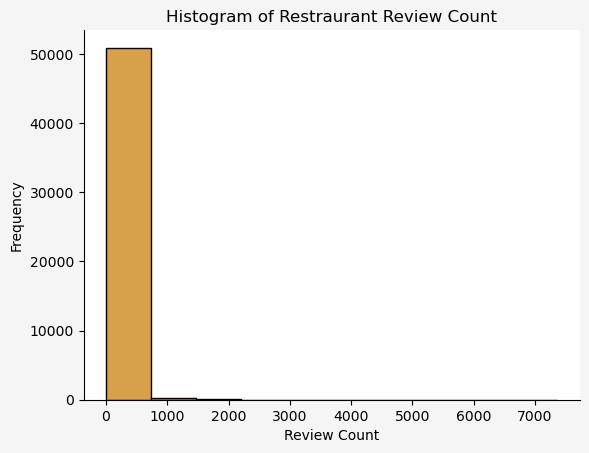

In [8]:
fig, ax = plt.subplots()
yelp_rest.plot(kind = "hist", y = "review_count", 
               color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Review Count")
ax.set_title("Histogram of Restraurant Review Count")
fig.set_facecolor((0.96, 0.96, 0.96))

This histogram of restaurant review count without outliers is extremely right-skewed. This implies that there are few popular restaurants that tend to attract more customers and thus receive much more reviews than most restaurants that receive less than 200 reviews.

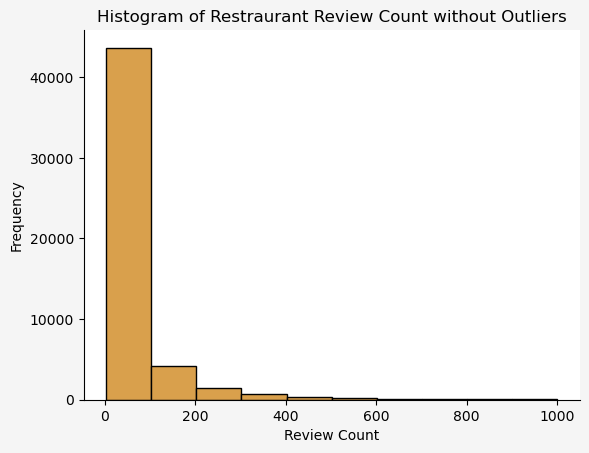

In [117]:
fig, ax = plt.subplots()
yelp_review.plot(kind = "hist", y = "review_count", 
                 color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Review Count")
ax.set_title("Histogram of Restraurant Review Count without Outliers")
fig.set_facecolor((0.96, 0.96, 0.96))

Most Yelp restaurants have less than 5000 check-ins. This histogram of the number of restaurant check-ins is not informative because it includes extreme outliers, such as number of check-ins over 30000. Thus, I decided to make another histogram that excludes restaurants with more than 5000 check-ins.

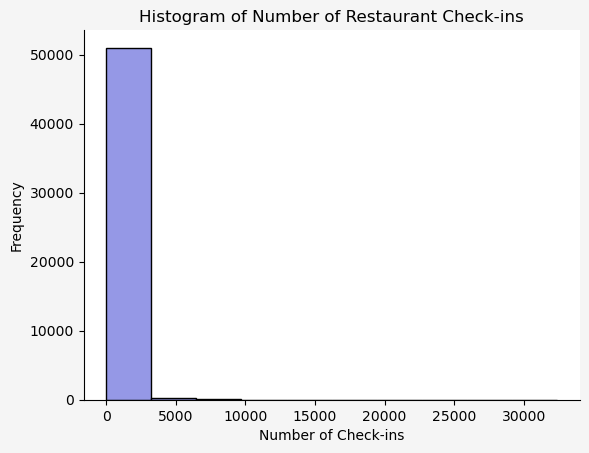

In [116]:
fig, ax = plt.subplots()
yelp_rest.plot(kind = "hist", y = "checkins", 
               color=mplc.hsv_to_rgb((0.66, 0.35, 0.9)), legend=False, ax = ax, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Check-ins")
ax.set_title("Histogram of Number of Restaurant Check-ins")
fig.set_facecolor((0.96, 0.96, 0.96))

This histogram of number of restaurant check-ins without outliers is extremely right-skewed.  This implies that there are few popular restaurants that tend to attract more customers and thus are checked into on Yelp much more frequently than most restaurants that have less than 1000 check-ins.

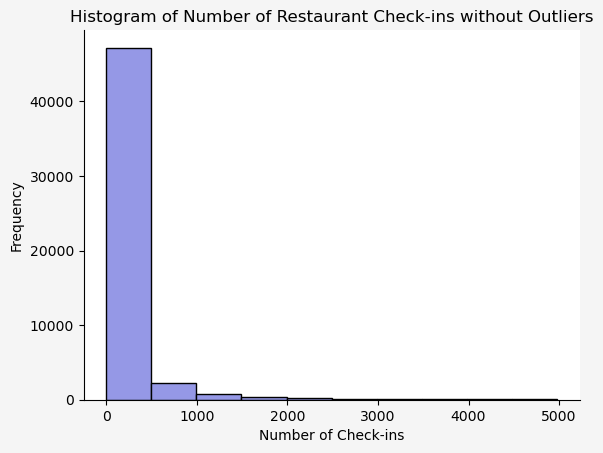

In [115]:
fig, ax = plt.subplots()
yelp_checkins.plot(kind = "hist", y = "checkins", 
                   color=mplc.hsv_to_rgb((0.66, 0.35, 0.9)), legend=False, ax = ax, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Check-ins")
ax.set_title("Histogram of Number of Restaurant Check-ins without Outliers")
fig.set_facecolor((0.96, 0.96, 0.96))

The histogram of restaurant rating is slightly left-skewed. This is because customers tend to give higher ratings to restaurants even if their experience was not exceptional, which makes the majority of ratings for restaurants higher (between 3 to 4 stars).

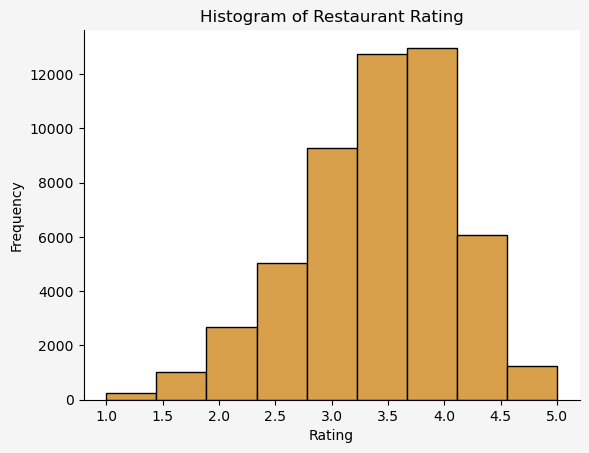

In [114]:
fig, ax = plt.subplots()
yelp_rest.plot(kind = "hist", y = "stars", 
               color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, bins = 9, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Rating")
ax.set_title("Histogram of Restaurant Rating")
fig.set_facecolor((0.96, 0.96, 0.96))

The histogram of restaurant days of operation is left-skewed because most restaurants open 6 to 7 days a week in order to accommodate varying schedules/dining preferences of customers.

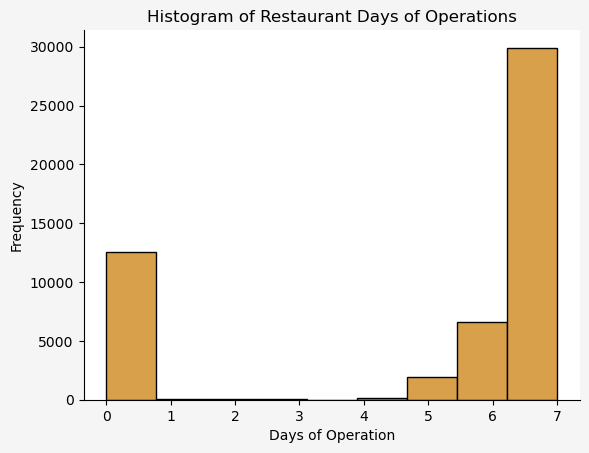

In [119]:
fig, ax = plt.subplots()
yelp_rest.plot(kind = "hist", y = "num_days", 
               color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, bins = 9, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Days of Operation")
ax.set_title("Histogram of Restaurant Days of Operations")
fig.set_facecolor((0.96, 0.96, 0.96))

The barplot of restaurant availability of parking shows that most restaurants do not have parking options or services available. This might because the cost of offering parking is too high compared to the profit it generates. 

Text(0.5, 1.0, 'Barplot of Restaurant Availability of Parking')

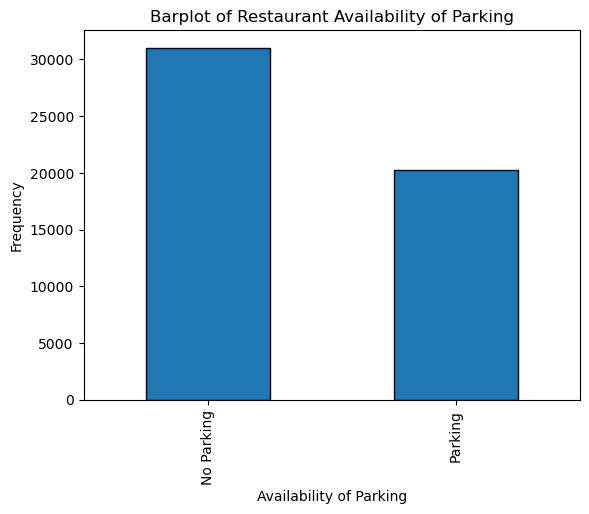

In [136]:
yelp_rest["parking"].value_counts().to_frame().rename(index={"False": 
"No Parking", "True": "Parking"}).plot(kind="bar", ec='black', legend=False)
plt.xlabel("Availability of Parking")
plt.ylabel("Frequency")
plt.title("Barplot of Restaurant Availability of Parking")

The boxplot of restaurant availability of parking vs rating shows that the distributions of rating are similar between restaurants with no parking options or services and restaurants with at least one parking options or services. This suggests that availability of parking is not a significant factor determining restaurant rating. One possible explanation is that customers have other priorities, such as the quality of food or service, over availability of parking when choosing a restaurant. Another possible explanation is that most restaurants locate in large and populated areas with limited parking options, but these restaurants might still receive high ratings despite the lack of available parking. Thus, restaurants should not make large investments in parking.

Text(0.5, 1.0, 'Boxplot of Restaurant Availability of Parking vs Rating')

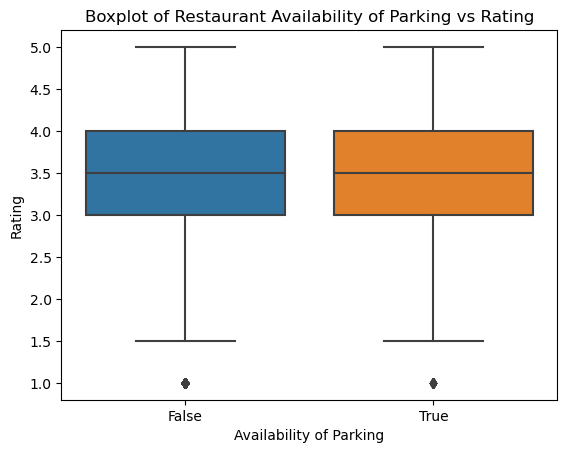

In [184]:
sns.boxplot(x="parking", y="stars", data=yelp_rest)
plt.xlabel("Availability of Parking")
plt.ylabel("Rating")
plt.title("Boxplot of Restaurant Availability of Parking vs Rating")

This barplot of restaurant city location shows the number of restaurants in the top 5 cities where most restaurants locate and in other cities. Most restaurants do not locate in Toronto, Las Vegas, Phoenix, Montreal, Charlotte.

Text(0.5, 1.0, 'Barplot of Restaurant City Location')

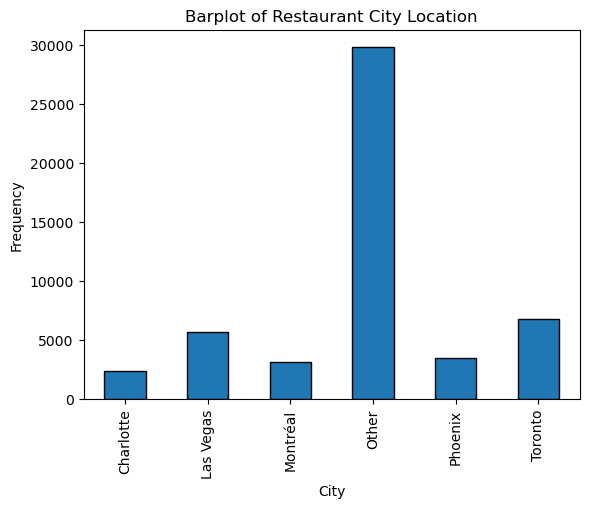

In [129]:
yelp_rest["city_graph"].value_counts().sort_index().plot(kind="bar", ec='black')
plt.xlabel("City")
plt.ylabel("Frequency")
plt.title("Barplot of Restaurant City Location")

From the boxplot of restaurant city location vs rating, the distributions of rating for restaurants in Charlotte, Toronto, Phoenix, Las Vegas, and other cities are different from the distribution of rating for restaurants in Montreal. The distributions of rating for restaurants in Montreal is more left-skewed due to some extreme outliers. On average, restaurants in Montreal have slightly higher ratings, but restaurants in cities other than Montreal have similar average ratings. Thus, city location might not significantly affect restaurant rating.

Text(0.5, 1.0, 'Boxplot of Restaurant City Location vs Rating')

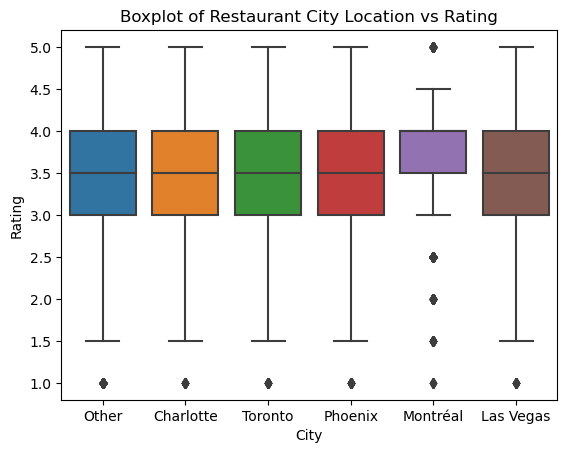

In [187]:
sns.boxplot(x="city_graph", y="stars", data=yelp_rest)
plt.xlabel("City")
plt.ylabel("Rating")
plt.title("Boxplot of Restaurant City Location vs Rating")

Because average days of operation across different ratings differ slightly, there is a weak relationship between restaurant rating and days of operation. In general, highly-rated restaurants tend to have higher average days of operation, which suggests that restaurant rating is positively correlated with days of operation. However, this is not always the case. This is because restaurants opening more days in a week provide flexibility and convenience to customers, which make them more highly-rated than restaurants opening less days a week. For example, restaurants with 5-star rating have lower average days of operation than restaurants with 4-star rating.

Text(0.5, 1.0, 'Relationship Between Restaurant Rating and Days of Operation')

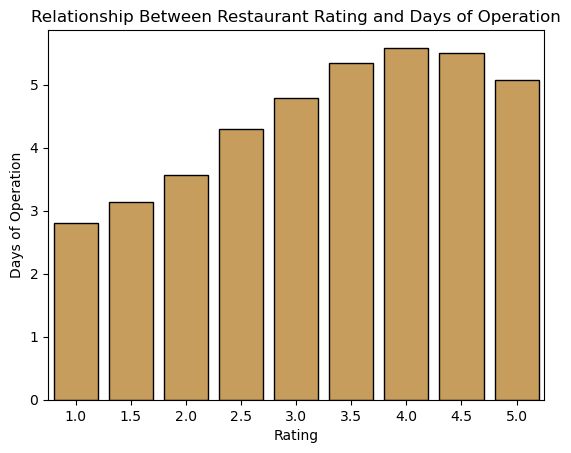

In [122]:
sns.barplot(x="stars", y="num_days", data=yelp_rest, 
            color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), 
            ci=None, ec='black')
plt.xlabel("Rating")
plt.ylabel("Days of Operation")
plt.title("Relationship Between Restaurant Rating and Days of Operation")

Because average review counts across different ratings differ significantly, there is a relationship between restaurant rating and review count. In general, highly-rated restaurants tend to have higher average review counts, which suggests that restaurant rating is positively correlated with review count. This is because large number of reviews reflects high popularity of restaurant, and popular restaurants are more likely to receive higher ratings. However, this is not always the case. Fo example, restaurants with 5-star rating have lower average review counts than restaurants with 4-star rating.

Text(0.5, 1.0, 'Relationship Between Review Count and Restaurant Rating')

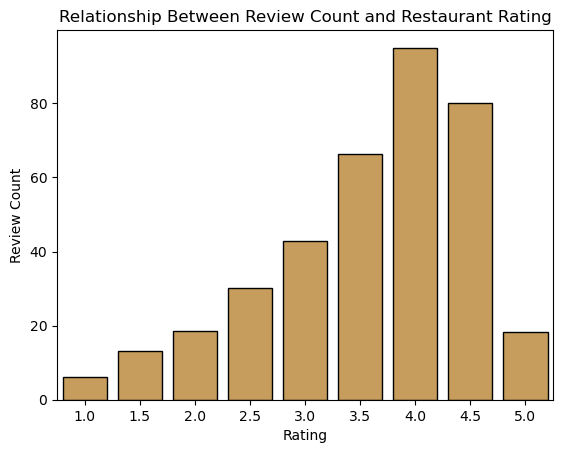

In [121]:
sns.barplot(x="stars", y="review_count", data=yelp_rest, 
            color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), 
            ci=None, ec='black')
plt.xlabel("Rating")
plt.ylabel("Review Count")
plt.title("Relationship Between Review Count and Restaurant Rating")

Because average number of check-ins across different ratings differ significantly, there is a relationship between restaurant rating and number of check-ins. In general, highly-rated restaurants tend to have higher average numbers of check-ins, which suggests that restaurant rating is positively correlated with number of check-ins. This is because large number of check-ins reflects high popularity of restaurant, and popular restaurants are more likely to receive higher ratings. However, this is not always the case. For example, restaurants with 5-star rating have lower average number of check-ins than restaurants with 4-star rating.

Text(0.5, 1.0, 'Relationship Between Number of Check-ins and Restaurant Rating')

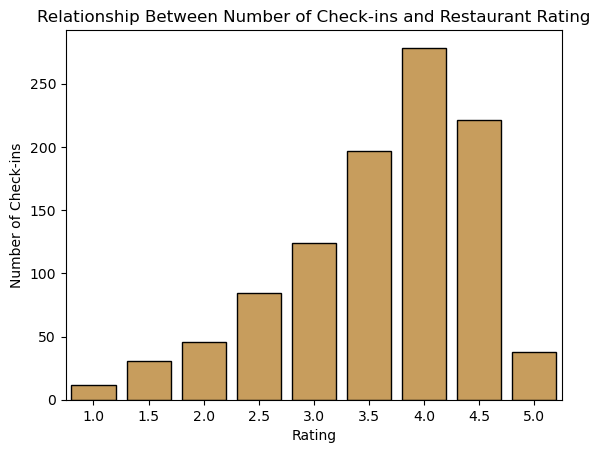

In [120]:
sns.barplot(x="stars", y="checkins", data=yelp_rest, 
            color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), 
            ci=None, ec='black')
plt.xlabel("Rating")
plt.ylabel("Number of Check-ins")
plt.title("Relationship Between Number of Check-ins and Restaurant Rating")

# Project Two

## The Message

Does restaurant rating differs significantly by the number of reviews?

The color of the bar is determined by review count. The bright red bar indicates that the number of reviews is above the 75 percentile; the medium red bar indicates that the number of reviews is between the 75 percentile and the median; the light red bar indicates that the number of reviews is below the median. 

Restaurants with moderate or relatively high ratings have higher review count than restaurants with extremely low or high ratings. This shows that in general restaurants that receive high number of reviews (their review counts are higher than median review count) are more likely to have higher ratings from customers. Thus, the number of reviews is an important factor affecting restaurant rating and is positively correlated with restaurant rating. 

The number of reviews of a restaurant influences customers's intention to visit, which indicates the popularity of a restaurant among customers (Zhang et al., 2010). Restaurants with high number of reviews are more likely to attract the interest of customers and become more popular. Also, more popular restaurants tend to get higher ratings (Kovács et al., 2013). This explains the positive relationship between restaurant rating and the number of reviews.

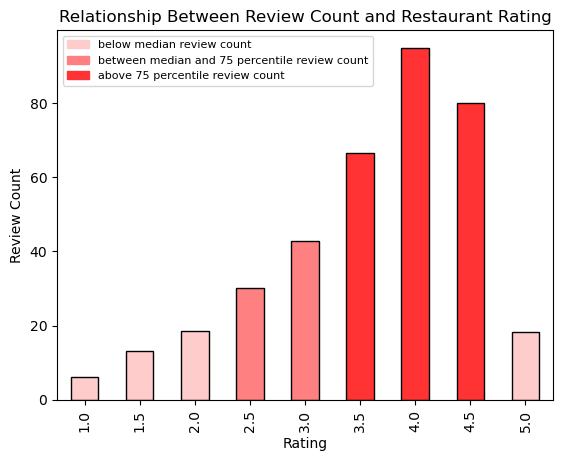

In [155]:
message = yelp_rest.pivot_table(values="review_count", index="stars")
fig, ax = plt.subplots()
colors = [mplc.hsv_to_rgb((0, 0.2, 1))] * 3 
colors += [mplc.hsv_to_rgb((0, 0.5, 1))] * 2 
colors += [mplc.hsv_to_rgb((0, 0.8, 1))] * 3 
colors += [mplc.hsv_to_rgb((0, 0.2, 1))] * 1
message.plot(kind="bar", y="review_count", ax=ax, ec='black', color=colors, legend=True)
plt.xlabel("Rating")
plt.ylabel("Review Count")
plt.title("Relationship Between Review Count and Restaurant Rating")
colors = {'below median review count': mplc.hsv_to_rgb((0, 0.2, 1)), 
          'between median and 75 percentile review count': mplc.hsv_to_rgb((0, 0.5, 1)),
          'above 75 percentile review count': mplc.hsv_to_rgb((0, 0.8, 1))}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, fontsize=8)

## Maps and Interpretations

In [12]:
# delete the row that has wrong location: Edinburgh
# does not have latitude 89.999314 and longtitude 
# -142.46665; since it's closed now, it makes sense
# to exclude it from my analysis
yelp_rest = yelp_rest.drop([26734])

Below is the world map of restaurant locations, and each dot represents a restaurant in the Yelp dataset. The map shows that most Yelp restaurants locate in Canada, the United States, and Europe. Some outlier locations include China, Chile, Argentina, and the Caribbean. 

In the world map, dots are small and they cluster together. It's hard to display more accurate locations of restaurants through the world map. This makes the world map not informative because knowing the countries in which restaurants locate does not provide any useful information for my analysis. It is more practical to display restaurant locations on a smaller geographic scale such as country. 

Thus, I decided to focus only on restaurants located in the United States, since restaurants in the United States account for 60.5% of all restaurants in the Yelp dataset. The sample of restaurants in the United States is a larger sample that would be more representative of all restaurants in the world than a sample of restaurants in Europe or Canada.

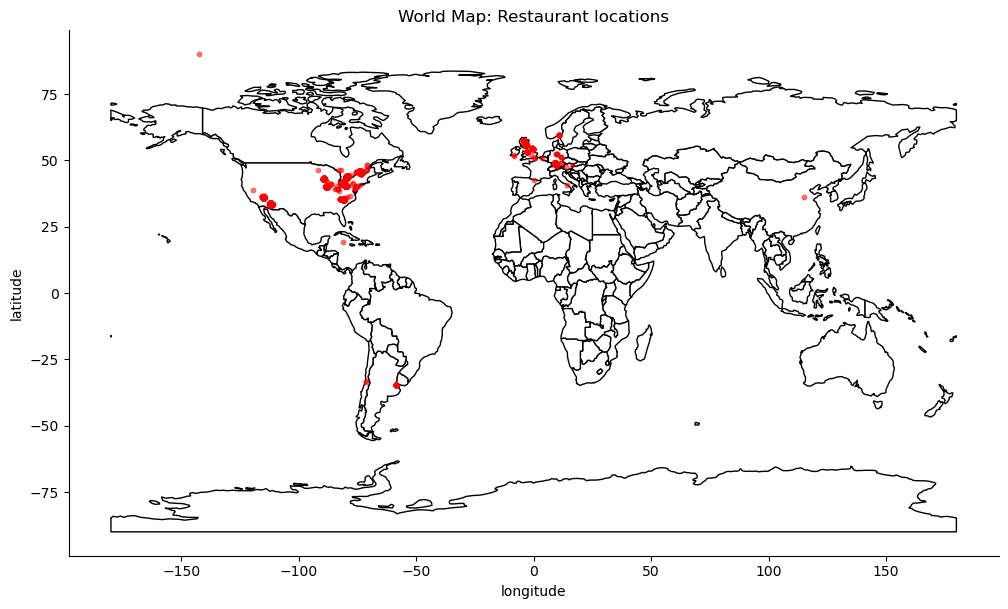

In [9]:
# read the file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# make the geodataframe
yelp_rest["coordinates"] = list(zip(yelp_rest.longitude, yelp_rest.latitude))
yelp_rest["coordinates"] = yelp_rest["coordinates"].apply(Point)
yelp_rest_gdf = gpd.GeoDataFrame(yelp_rest, crs = 4269, geometry="coordinates")
# plotting
fig, gax = plt.subplots(figsize=(12,12))
# plot the world
world.plot(ax=gax, edgecolor='black',color='white')
# plot the restaurants
yelp_rest_gdf.plot(ax=gax, color='red', alpha = 0.5, markersize = 10)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title("World Map: Restaurant locations")
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()

In [10]:
us_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_nation_5m.zip")
# rest_us_merge only includes restaurants in the US
rest_us_merge = gpd.sjoin(yelp_rest_gdf, us_df, op="within")
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
# state only includes US territories on the mainland
state = state_df[~(state_df.STUSPS.isin(["AK", "HI", "VI", "MP", "AS", "PR", "GU"]))]

In [11]:
# find which state the coordinates belong to
rest_us_merge1 = gpd.sjoin(yelp_rest_gdf, state, op="within")
rest_us_merge1 = rest_us_merge1.reset_index()
# state_rating includes average rating of 
# US restaurants in each state
state_rating = rest_us_merge1.pivot_table(values="stars", index="NAME") 
state_rating = state_rating.reset_index()
# add state information and make the geodataframe
merge_state = pd.merge(state_rating, state, on="NAME")
merge_state_gdf = gpd.GeoDataFrame(merge_state, crs = 4269, geometry="geometry")

The map shows average restaurant rating per state for the 14 US states in the Yelp dataset. On average, restaurants in these 14 states have relatively high average ratings (above 3 stars). This coincides with my previous findings that customers usually give high ratings to restaurants. Restaurants in Kentucky, Virginia, and New Jersey have higher average ratings (about 4 stars) than restaurants in the other 11 states. This map is another illustration that describes features of rating for Yelp restaurants in the United States.

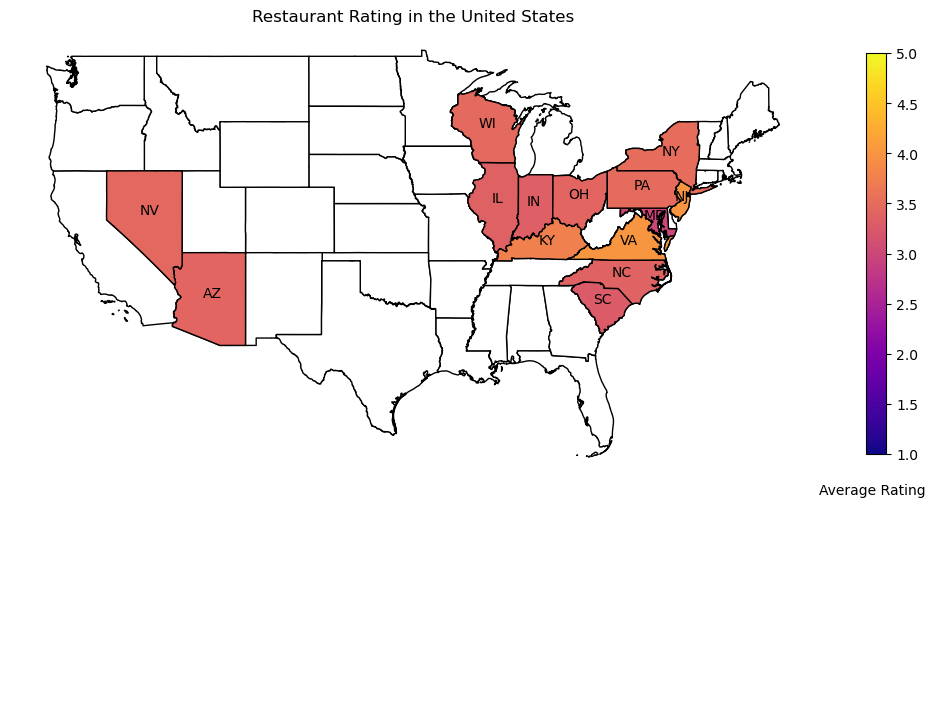

In [445]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black', color='white')
# plot the states
merge_state_gdf.plot(ax=gax, edgecolor='black', column='stars', legend=True, 
                 legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=1, vmax=5)
# label the states
merge_state_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
    
gax.set_title("Restaurant Rating in the United States")
gax.annotate('Average Rating', xy=(0.63, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

In [12]:
# state_review includes average review count of 
# US restaurants in each state
state_review = rest_us_merge1.pivot_table(values="review_count", index="NAME") 
state_review = state_review.reset_index()
# add state information and make the geodataframe
merge_state1 = pd.merge(state_review, state, on="NAME")
merge_state1_gdf = gpd.GeoDataFrame(merge_state1, crs = 4269, geometry="geometry")

The map shows average restaurant review count per state for the 14 US states in the Yelp dataset. It's reasonable to set the upper limit of average review count to 200 because the maximum average review count per state is around 151.

Restaurants in most of the 14 states have relatively low average review count (below 60 reviews). Restaurants in Arizona and Nevada have much higher average review count (above 90 reviews) than restaurants in the other 12 states. This coincides with my previous findings that most restaurants have low review counts while few extremely popular restaurants have much higher review counts. This map is another illustration that describes features of review count for Yelp restaurants in the United States.

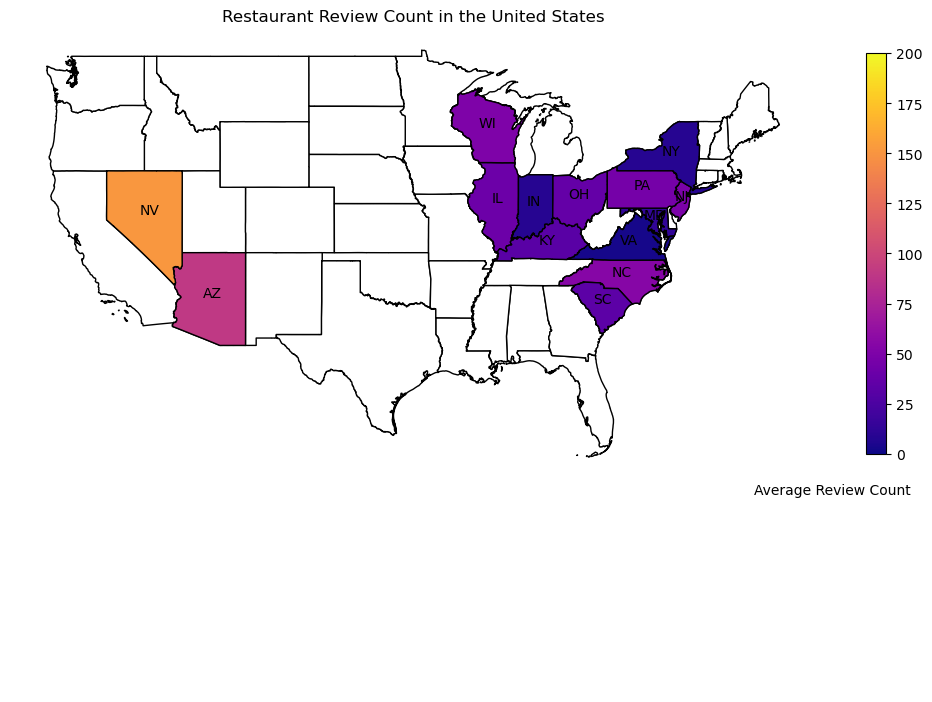

In [444]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black', color='white')
# plot the states 
merge_state1_gdf.plot(ax=gax, edgecolor='black', column='review_count', legend=True, 
                      legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=0, vmax=200)
# label the states
merge_state1_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

gax.set_title("Restaurant Review Count in the United States")
gax.annotate('Average Review Count', xy=(0.58, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

In [369]:
# create a new variable review that categorizes 
# review_count into two groups: "above 20" has 
# review count greater than or equal to 20 and 
#"below 20" has review count lower than 20
rest_us_merge1["review"] = ""
for i in range(rest_us_merge1.shape[0]):
    if rest_us_merge1["review_count"][i] >= 20:
        rest_us_merge1["review"][i] = "above 20"
    else: 
        rest_us_merge1["review"][i] = "below 20"

In [370]:
rest_us_merge1_gby_review = rest_us_merge1.groupby("review")
# rest_us_merge1_above includes US restaurants with review
# count above median review count
rest_us_merge1_above = rest_us_merge1_gby_review.get_group("above 20")
rest_us_merge1_above = rest_us_merge1_above.reset_index(drop=True)
# rest_us_merge1_below includes US restaurants with review
# count below median review count
rest_us_merge1_below = rest_us_merge1_gby_review.get_group("below 20")
rest_us_merge1_below = rest_us_merge1_below.reset_index(drop=True)

In [371]:
# state_review_above includes average rating of US
# restaurants with high review counts in each state
state_review_above = rest_us_merge1_above.pivot_table(values="stars", index="NAME") 
state_review_above = state_review_above.reset_index()
# add state information and make the geodataframe
merge_state2 = pd.merge(state_review_above, state, on="NAME")
merge_state2_gdf = gpd.GeoDataFrame(merge_state2, crs = 4269, geometry="geometry")

In [372]:
# state_review_below includes average rating of US 
# restaurants with low review counts in each state
state_review_below = rest_us_merge1_below.pivot_table(values="stars", index="NAME") 
state_review_below = state_review_below.reset_index()
# add state information and make the geodataframe
merge_state3 = pd.merge(state_review_below, state, on="NAME")
merge_state3_gdf = gpd.GeoDataFrame(merge_state3, crs = 4269, geometry="geometry")

The average restaurant ratings for all of the 14 US states in the Yelp dataset are between 3 to 4 stars. Thus, it's reasonable to change the scale of average rating to be between 3 to 4 stars for the following two maps in order to examine the effect of high/low review count on restaurant rating more closely. Note that high review count means review count greater than or equal to average review count; low review count means review count lower average review count.

The map shows average rating of Yelp restaurants with low review counts per state for the 13 US states. Note that there are no restaurants with low review counts in New Jersey. Restaurants with low review counts in most of the 13 states have average ratings close to 3 stars. Restaurants with low review counts in Kentucky and Virginia have higher average ratings (close to 4 stars) than restaurants with low review counts in the other 11 states. This map is an illustration that describes features of rating for Yelp restaurants with low review counts in the United States.

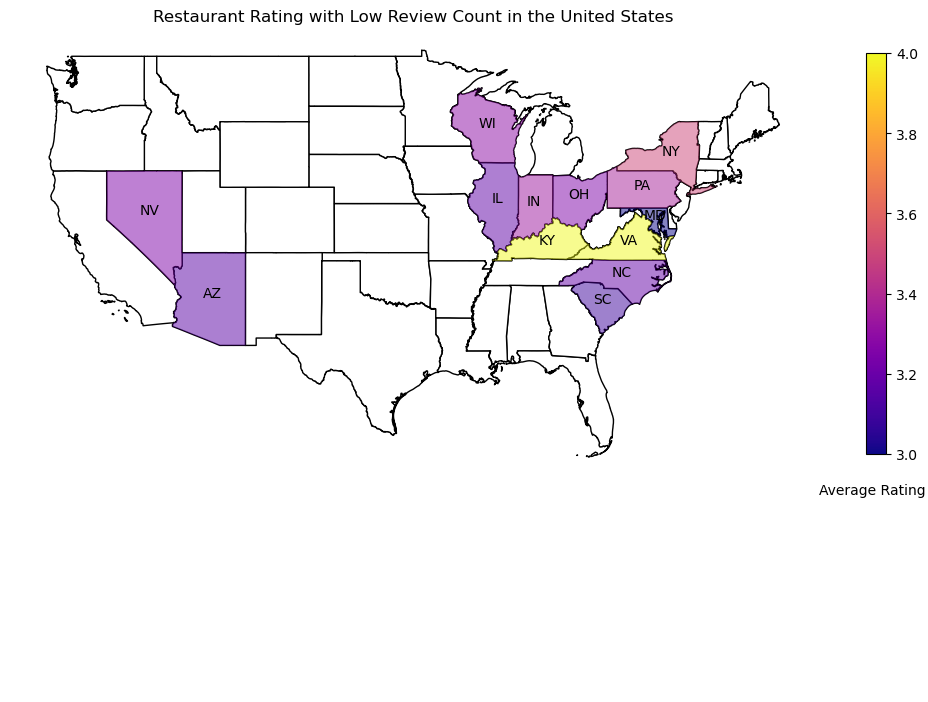

In [446]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black',color='white')
# plot the cities 
merge_state3_gdf.plot(ax=gax, column='stars', legend=True, alpha = 0.5,  
                          legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=3, vmax=4)
# label the states
merge_state3_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

gax.set_title("Restaurant Rating with Low Review Count in the United States")
gax.annotate('Average Rating', xy=(0.63, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

The map shows average rating of Yelp restaurants with high review counts per state for the 10 US states. Note that there are no restaurants with high review counts in Virginia, Illinois, New York, and Maryland. Restaurants with high review counts in all of the 10 states have average ratings close to 3.5 stars. This map is an illustration that describes features of rating for Yelp restaurants with high review counts in the United States.

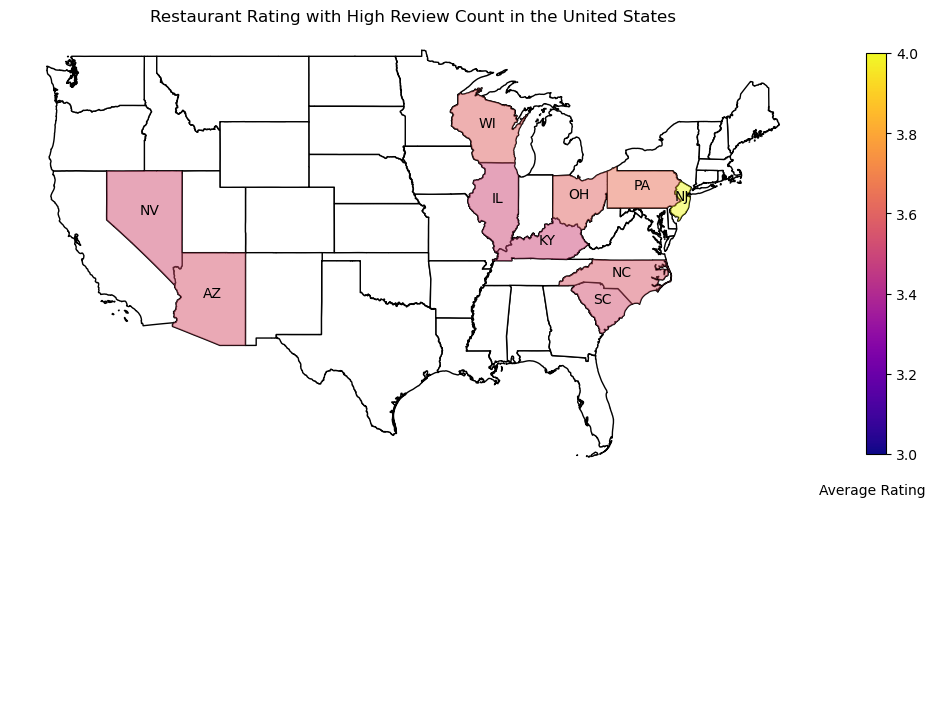

In [447]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black',color='white')
# plot the cities 
merge_state2_gdf.plot(ax=gax, column='stars', legend=True, alpha = 0.5, 
                          legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=3, vmax=4)
# label the states
merge_state2_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

gax.set_title("Restaurant Rating with High Review Count in the United States")
gax.annotate('Average Rating', xy=(0.63, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

The two maps about restaurant rating with high/low review count in the United States show a relationship between restaurant rating and review count. For the 10 states (exlcuding Virginia, Illinois, New York, and Maryland, which have no data for Yelp restaurants with high review counts, and New Jersey, which has no data for Yelp restaurants with low review counts), restaurants with high review counts generally have higher average ratings than restaurants with low review counts. This coincides with my previous findings that restaurant rating is positively correlated with reveiw count. One exception is in Kentucky, where restaurants with low review counts have higher average ratings than restaurants with high review counts. 

# Project Three

## Potential Data to Scrape

The website I would want to scrape is 

https://www.yelp.com/search?find_desc=Restaurants&find_loc=Kensington%20Market%2C%20Toronto%2C%20ON%2C%20Canada

This website contains data about Yelp restaurants such as name, rating, review count, business hours, and location of the restaurant that are already in my Yelp dataset. However, it also has one important information about Yelp restaurants that requires web scrapping: restaurant price. Restaurant price, which is the average cost per person for a meal in the restaurant, is represented by the number of dollar signs. The maximum number of dollar signs is 4; the mimimum number of dollar signs is 1. The higher the number of dollar signs, the more expensive the restaurant is. 

Restaurant price can be a significant factor that impacts its rating. A study from Harvard Business School proposes that higher prices lead to lower restaurant ratings (Luca & Reshef, 2021). There is an obvious explanation for this trend: customers who pay more for a meal in the restaurant often have higher expectations, and if those expectations are not met, they are more likely to give lower ratings. Including restaurant price in my analysis and examining the correlation between restaurant rating and price are important because if any relationship is found, it provides additional insights for improvements of restaurant reputation. It could help restaurant owners to decide how they should adjust prices to improve customers satisfaction and thus attract more customers. 

If I could scrape this data from the website, I would merge it with my Yelp restaurant dataset by restaurant name and location (since chain restaurants have the same names but different locations). This allows me to get the number of dollar signs corresponding to each Yelp restaurant. If there is no price information for a restaurant, then price is N/A for this restaurant. I would categorize price into four levels (inexpensive, moderate, expensive, and extremely expensive) based on the number of dollar signs and then use visualizations, such as scatterplot, to see if there exists some link between different price levels and restaurant rating.

## Potential Challenges

It's possible to extract restaurant price from the website using HTML scrapping. However, the biggest challenge is that I would need to manually specify location because the website only displays restaurants near a specific location. For example, I could only obtain restaurant information in Toronto using the link above. In order to obtain price information for all Yelp restaurants, I would need to manually search for each location in my Yelp restaurant dataset and perform HTML scrapping to obtain restaurant price information for this specific location. Since there are 744 different cities in my Yelp restaurant dataset, it would likely take a long time for me to obtain price information for all Yelp restaurants. Also, I would need to run my scrapping program probably annually to update restaurant price because restaurants might raise their prices to adjust inflation or other cost changes.

Since scrapping this source requires me to manually specify location and run my program annually, all of which are time-consuming processes, I would need to learn how to write simpler, more efficient code for web scrapping to reduce the time to complete these processes.

## Scraping Data from a Website

I will be scrapping from Labor Law Center (https://www.laborlawcenter.com/state-minimum-wage-rates). This website contains data about minimum wage by states in the United States from 2013 to 2023. Since the Yelp dataset was published 5 years ago, I scrape the minimum wage by state data for the same year, which is 2018, to maintain consistency. The scrapped data would include state name and minimum wage in 2018 corresponding to each state.

The code below requests the URL for the web content and then parses through HTML content to understand its complete structure. The parsed HTML is stored in a soup object (a more structured content which I'm trying to scrap).

In [13]:
import requests
import urllib.request
from bs4 import BeautifulSoup

url = 'https://www.laborlawcenter.com/state-minimum-wage-rates'
response = requests.get(url)
soup_object = BeautifulSoup(response.content)

The code below extracts the relevant block of data by searching for the first table with class attribute 'simple' and then extracts the row values enclosed by `<tr>` HTML tag. The row values are the values in each row of the table.

In [14]:
data_table = soup_object.find_all('table', 'simple')[0]
all_values = data_table.find_all('tr')

The code below first creates an empty dataframe with column names 'State' and 'min wage ($)'. The index is initiated to zero. Then, the for loop goes through all the elements in a row of the table in order and extracts the state name and minimum wage from 2013 to 2023 which are enclosed in the `<td>` HTML tag from each row. The text parts of state name and minimum wage in 2018 (with dollar sign removed) are picked from the `<td>` HTML tag. These values are then put into the dataframe and the index value is incremented. The steps are repeated for each row in the table. Finally, the dataframe is saved into a csv file.

In [15]:
min_wage = pd.DataFrame(columns = ['State', 'min wage ($)']) # Create an empty dataframe
ix = 0 # Initialise index to zero

for row in all_values[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    state = values[0].text
    year = values[6].text.strip("$")
    
    min_wage.loc[ix] = [state, year] # Store it in the dataframe as a row
    ix += 1
min_wage.to_csv('minwage_2018_by_states.csv', index=False)

In [334]:
min_wage.head()

,State,min wage ($)
0,Alabama,7.25
1,Alaska,9.84
2,Arizona,10.50
3,Arkansas,8.50
4,California,11.00


## Merging the Scraped Dataset

I obtain data about CPI by states in 2018 in order to calculate real minimum wage. This data come from US Bureau of Labor Statistics (https://www.bls.gov/cpi/regional-resources.htm). This website only provides regional CPI (there are four regions: northeast, west, midwest, and south) and CPI in some metro areas. Thus, if CPI in a metro area is provided for a state that this metro area, I use CPI in the metro area for this state; otherwise, I use regional CPI for this state. For example, I use CPI in Chicago, instead of midwest CPI, for Illinois. 

The base period is 1982-1984. Note that I only include CPI information for some states. It's reasonable to do so because the Yelp restaurants in my dataset only locate in these 14 states. The purpose here is just to save my time without losing any necessary information. I merge CPI dataset with minimum wage dataset by state and calculate real minimum wage by the following formula: real minimum wage = nominal minimum wage / CPI * 100.

In [16]:
minwage = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/minwage_2018_by_states.csv")
minwage["State"] = minwage["State"].str.strip()

In [17]:
CPI_df = pd.DataFrame({
    "State" : ["Arizona", "Illinois", "Indiana", "Nevada", 
               "New Jersey", "New York", "North Carolina",
               "Ohio", "Pennsylvania", "South Carolina",
               "Wisconsin", "Maryland", "Kentucky", "Virginia"],
    "CPI" : [263.263, 237.706, 234.290, 263.263,
             265.139, 273.641, 242.737, 
             234.290, 251.563, 242.737,
             234.290, 242.737, 242.737, 242.737]})

In [18]:
# left merge the minimum wage data with the CPI data
wage_cpi = pd.merge(minwage, CPI_df, on="State", how="left")
# calculate real minimum wage 
wage_cpi["real min wage ($)"] = wage_cpi["min wage ($)"] / wage_cpi["CPI"] * 100

After I merge the minimum wage (nominal and real) by state in 2018 data with my Yelp restaurant dataset, the new data has a total of 31039 observations. This new data now includes information about real minimum wage in 2018 of the state in which each Yelp restaurant locates in the United States. 

In [19]:
# left merge the minimum wage by state in 2018 data with
# the data that includes US restaurants only
yelp_realwage = pd.merge(rest_us_merge1, wage_cpi, left_on="NAME", right_on="State", how="left")

## Visualizing the Scraped Dataset

The histogram of state real minimum wage shows that all Yelp restaurants need to pay real minmimum wages ranging from about 3 to 4 dollars per hour to their workers. However, under state minimum wage laws, some Yelp restaurants can pay  approximately a dollar less (in real terms) per hour to their workers than other Yelp restaurants. This difference is striking in terms of labor costs of the restaurant. Holding other things equal, Yelp restaurants paying higher state real minimum wage incur more labor costs and might need to pass these higher costs on to consumers, which might lead to lower ratings.

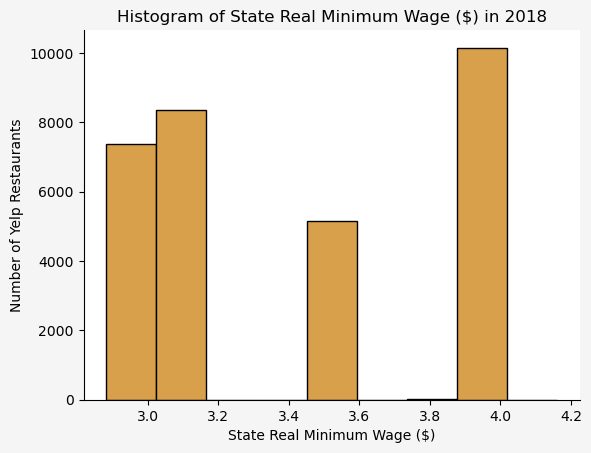

In [600]:
fig, ax = plt.subplots()
yelp_realwage.plot(kind = "hist", y = "real min wage ($)", 
               color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, bins = 9, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("State Real Minimum Wage ($)")
ax.set_ylabel("Number of Yelp Restaurants")
ax.set_title("Histogram of State Real Minimum Wage ($) in 2018")
fig.set_facecolor((0.96, 0.96, 0.96))

In [164]:
# realwage_bystate includes required real min wage in each state 
realwage_bystate = yelp_realwage.pivot_table(values="real min wage ($)", index="State")
# rating_bystate includes average rating of Yelp
# restaurants in each state 
rating_bystate = yelp_realwage.pivot_table(values="stars", index="State")
# realwage_rating includes required real min wage and
# average rating of Yelp restaurants in state level
realwage_rating = pd.merge(realwage_bystate, rating_bystate, on="State", how="left")

In [428]:
# add state information and make the geodataframe
wage_state = pd.merge(realwage_rating, state, left_on="State", right_on="NAME")
wage_state_gdf = gpd.GeoDataFrame(wage_state, crs = 4269, geometry="geometry")

The map shows state real minimum wage for the 14 US states in the Yelp dataset. Note that I set the scale of state real minimum wage to be between 3 to 4 dollars because all state real minimum wages are approximately in this range. From the map, Arizona and Maryland have the highest real minimum wage requirements (around 4 dollars per hour), and most states require real minimum wage close to 3 dollars per hour. 

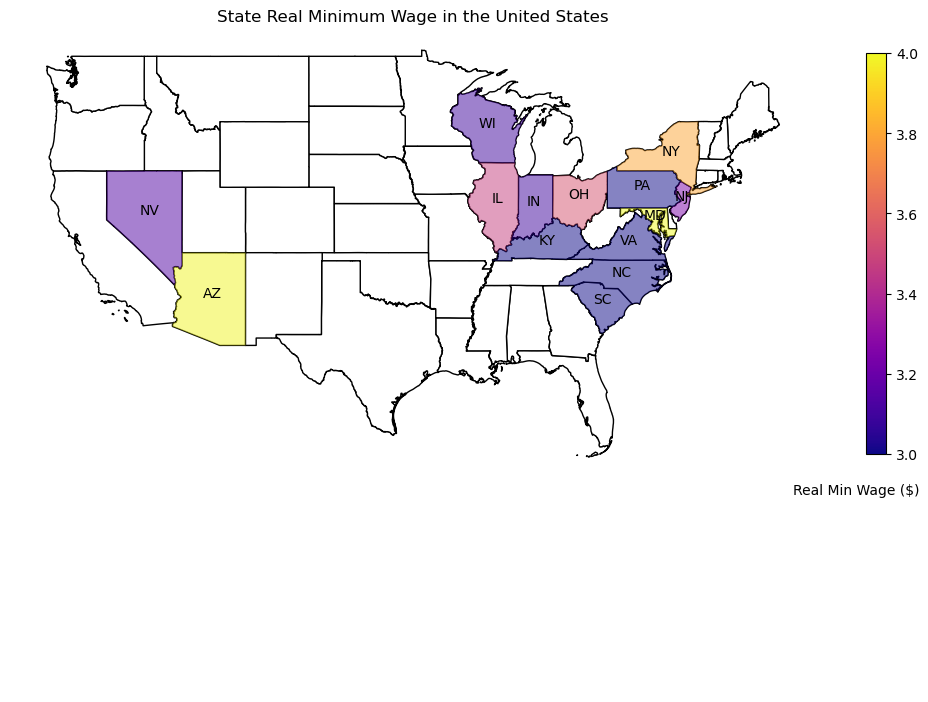

In [457]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black',color='white')
# plot the cities 
wage_state_gdf.plot(ax=gax, column='real min wage ($)', legend=True, alpha = 0.5, 
                          legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=3, vmax=4)
# label the states
wage_state_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

gax.set_title("State Real Minimum Wage in the United States")
gax.annotate('Real Min Wage ($)', xy=(0.61, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

This graph shows the relationship between real minimum wage and average restaurant rating at state level. Real minimum wage is negatively correlated with restauraing rating. This trend is also found in a study proposing that higher minimum wage is assoicated with a significant drop in restaurant ratings for 18 metro areas in the United States and Canada (Khanna, 2021). One possible explanation is that higher minimum wages are passed on through higher restaurant prices, and higher prices could lower ratings holding everything else constant. Also, restaurants paying higher minimum wage might need to cut spendings in food quality to minimize their costs, for example, which might be reflected in lower ratings.

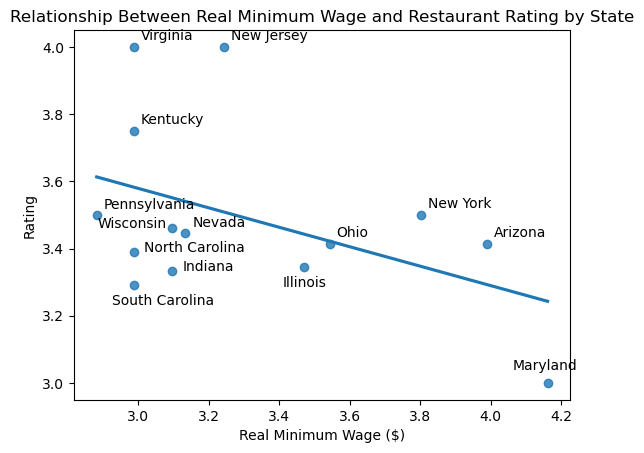

In [501]:
ax = sns.regplot(x="real min wage ($)", y="stars", data=realwage_rating, ci=None)
# add annotations
ax.annotate("Arizona", (realwage_rating["real min wage ($)"][0] + 0.02, 
                        realwage_rating["stars"][0] + 0.02))
ax.annotate("Illinois", (realwage_rating["real min wage ($)"][1] - 0.06, 
                        realwage_rating["stars"][1] - 0.06))
ax.annotate("Indiana", (realwage_rating["real min wage ($)"][2] + 0.03, 
                        realwage_rating["stars"][2]))
ax.annotate("Kentucky", (realwage_rating["real min wage ($)"][3] + 0.02, 
                        realwage_rating["stars"][3] + 0.02))
ax.annotate("Maryland", (realwage_rating["real min wage ($)"][4] - 0.1, 
                        realwage_rating["stars"][4] + 0.04))
ax.annotate("Nevada", (realwage_rating["real min wage ($)"][5] + 0.02, 
                        realwage_rating["stars"][5] + 0.02))
ax.annotate("New Jersey", (realwage_rating["real min wage ($)"][6] + 0.02, 
                        realwage_rating["stars"][6] + 0.02))
ax.annotate("New York", (realwage_rating["real min wage ($)"][7] + 0.02, 
                        realwage_rating["stars"][7] + 0.02))
ax.annotate("North Carolina", (realwage_rating["real min wage ($)"][8] + 0.03, 
                        realwage_rating["stars"][8]))
ax.annotate("Ohio", (realwage_rating["real min wage ($)"][9] + 0.02, 
                        realwage_rating["stars"][9] + 0.02))
ax.annotate("Pennsylvania", (realwage_rating["real min wage ($)"][10] + 0.02, 
                        realwage_rating["stars"][10] + 0.02))
ax.annotate("South Carolina", (realwage_rating["real min wage ($)"][11] - 0.06, 
                        realwage_rating["stars"][11] - 0.06))
ax.annotate("Virginia", (realwage_rating["real min wage ($)"][12] + 0.02, 
                        realwage_rating["stars"][12] + 0.02))
ax.annotate("Wisconsin", (realwage_rating["real min wage ($)"][13] - 0.21, 
                        realwage_rating["stars"][13]))

plt.xlabel("Real Minimum Wage ($)")
plt.ylabel("Rating")
plt.title("Relationship Between Real Minimum Wage and Restaurant Rating by State")
plt.show()

The table shows real minimum wage correponding to the states where Yelp restaurants locate. Real minimum wage approximately ranges from 3 to 4 dollars and does not vary greatly between states.

In [340]:
realwage_rating[["real min wage ($)"]]

,real min wage ($)
State,
Arizona,3.988407
Illinois,3.470674
Indiana,3.094456
Kentucky,2.986772
Maryland,4.160882
Nevada,3.133748
New Jersey,3.243582
New York,3.800600
North Carolina,2.986772


## Adding a New Dataset

This data comes from National Center for Education Statistics (https://nces.ed.gov/programs/digest/d19/tables/dt19_102.30.asp). This website provides median household income by state in selected years from 1990 to 2018. The median household income is in constant 2018 dollars, thus I don't need to adjust for inflation because I use Yelp restaurant dataset and minimum wage (nominal and real) by state data in 2018. I create a csv file that only includes median household income in 2018 and state name. 

In [20]:
income_file = pd.read_excel("/Users/jasmineyen/Downloads/ECO225Project/Data/median_household_income.xlsx")
income_file.to_csv("median_household_income.csv", index = None, header=True)
income_csv = pd.read_csv("/Users/jasmineyen/Downloads/ECO225Project/Data/median_household_income.csv")
income = pd.DataFrame({"State": income_csv["State"], 
                       "median household income ($)": income_csv["median household income"]})
income["State"] = income["State"].str.strip()

After I merge the median household income by state in 2018 data with my dataset, the new data now includes information about median household income in 2018 of the state in which each Yelp restaurant locates in the United States.

In [21]:
# left merge the median household income by state data with
# yelp restaurant with state minimum wage data 
yelp_wage_income = pd.merge(yelp_realwage, income, left_on="NAME", right_on="State", how="left")

The histogram of state median household income shows that most Yelp restaurants locate in the states where median household incomes are between 55,000 and 60,000 dollars. Few Yelp restaurants locate in the states where median household incomes are much higher than other states. This difference in median household incomes could have important impact on restaurant ratings. For example, Yelp restaurants in the states with high median household income might do better because high-income households have higher expectations, thus resulitng in higher ratings.

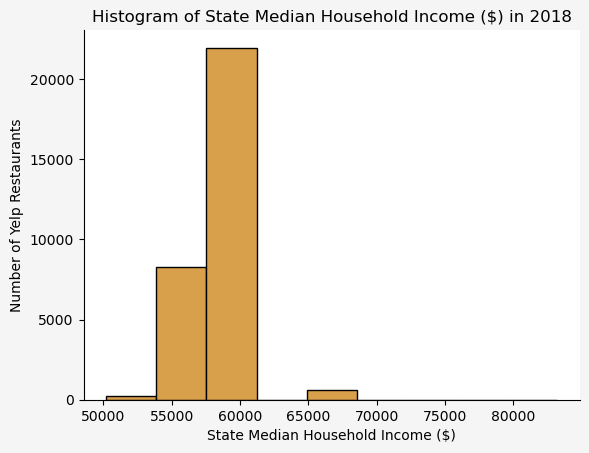

In [599]:
fig, ax = plt.subplots()
yelp_wage_income.plot(kind = "hist", y = "median household income ($)", 
               color=mplc.hsv_to_rgb((0.10, 0.65, 0.85)), legend=False, ax = ax, bins = 9, ec='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("State Median Household Income ($)")
ax.set_ylabel("Number of Yelp Restaurants")
ax.set_title("Histogram of State Median Household Income ($) in 2018")
fig.set_facecolor((0.96, 0.96, 0.96))

In [205]:
# income_rating includes median household income and
# average rating of Yelp restaurants in state level
income_rating = pd.merge(realwage_rating, income, on="State", how="left")

In [615]:
# add state information and make the geodataframe
income_state = pd.merge(income_rating, state, left_on="State", right_on="NAME")
income_state_gdf = gpd.GeoDataFrame(income_state, crs = 4269, geometry="geometry")

The map shows state median household income for the 14 US states in the Yelp dataset. Note that I set the scale of state median household income to be between 50,000 to 70,000 dollars because almost all median household incomes are in this range. From the map, Viriginia, Maryland, and New Jersey have the highest median household incomes (over 70,000 dollars), and most states have median household incomes between 55,000 and 65,000 dollars.

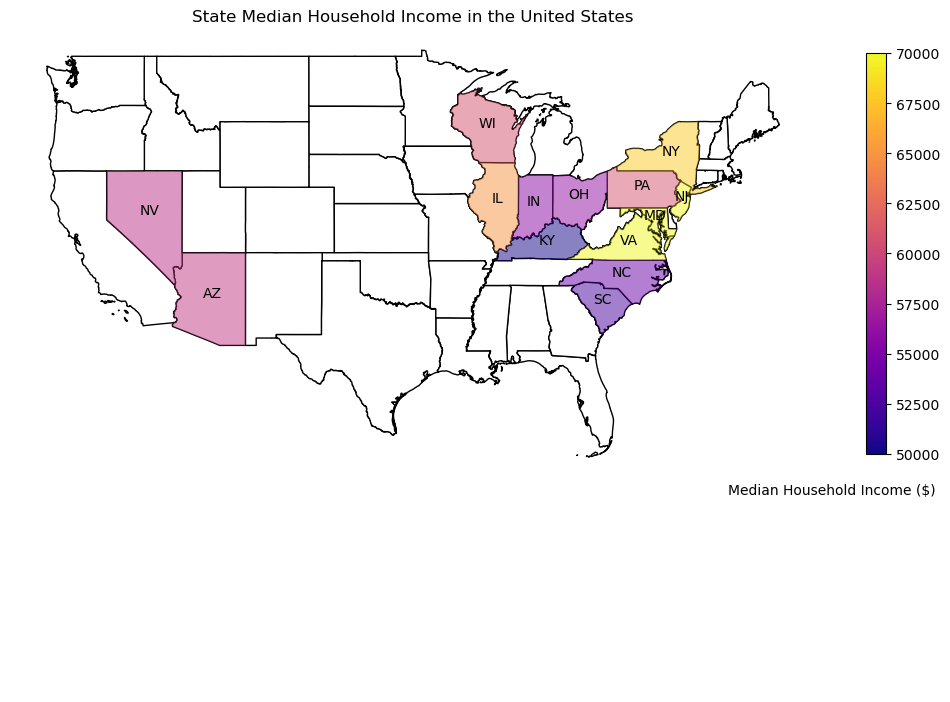

In [610]:
# plotting
fig, gax = plt.subplots(figsize=(13,13))
# plot the country
state.plot(ax=gax, edgecolor='black',color='white')
# plot the cities 
income_state_gdf.plot(ax=gax, column='median household income ($)', legend=True, alpha = 0.5, 
                          legend_kwds={"shrink": 0.4}, cmap="plasma", vmin=50000, vmax=70000)
# label the states
income_state_gdf.apply(lambda x: gax.annotate(text=x['STUSPS'], 
                      xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

gax.set_title("State Median Household Income in the United States")
gax.annotate('Median Household Income ($)', xy=(0.56, 0.16),  xycoords='figure fraction')
plt.axis('off')
plt.show()

This graph shows the relationship between median household income and average restaurant rating at state level. Median household income is positively correlated with restauraing rating. This is probably because restaurants tend to do better in order to fulfill higher expectations of households in richer states. Also, restaurants in richer states are able to afford higher-quality ingredients because they earn more from high-income households. These might lead to higher ratings for these restaurants.

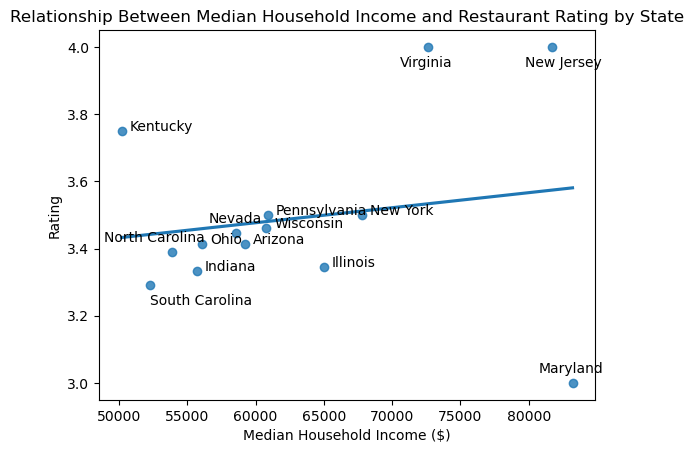

In [685]:
ax = sns.regplot(x="median household income ($)", y="stars", data=income_rating, ci=None)
# add annotations
ax.annotate("Arizona", (income_rating["median household income ($)"][0] + 600, 
                        income_rating["stars"][0]))
ax.annotate("Illinois", (income_rating["median household income ($)"][1] + 600, 
                        income_rating["stars"][1]))
ax.annotate("Indiana", (income_rating["median household income ($)"][2] + 600, 
                        income_rating["stars"][2]))
ax.annotate("Kentucky", (income_rating["median household income ($)"][3] + 600, 
                        income_rating["stars"][3]))
ax.annotate("Maryland", (income_rating["median household income ($)"][4] - 2500, 
                        income_rating["stars"][4] + 0.03))
ax.annotate("Nevada", (income_rating["median household income ($)"][5] - 2000, 
                        income_rating["stars"][5] + 0.03))
ax.annotate("New Jersey", (income_rating["median household income ($)"][6] - 2000, 
                        income_rating["stars"][6] - 0.06) )
ax.annotate("New York", (income_rating["median household income ($)"][7] + 600, 
                        income_rating["stars"][7]))
ax.annotate("North Carolina", (income_rating["median household income ($)"][8] - 5000, 
                        income_rating["stars"][8] + 0.03))
ax.annotate("Ohio", (income_rating["median household income ($)"][9] + 600, 
                        income_rating["stars"][9]))
ax.annotate("Pennsylvania", (income_rating["median household income ($)"][10] + 600, 
                        income_rating["stars"][10]))
ax.annotate("South Carolina", (income_rating["median household income ($)"][11] - 0.06, 
                        income_rating["stars"][11] - 0.06))
ax.annotate("Virginia", (income_rating["median household income ($)"][12] - 2000, 
                        income_rating["stars"][12] - 0.06))
ax.annotate("Wisconsin", (income_rating["median household income ($)"][13] + 600, 
                        income_rating["stars"][13]))

plt.xlabel("Median Household Income ($)")
plt.ylabel("Rating")
plt.title("Relationship Between Median Household Income and Restaurant Rating by State")
plt.show()

The table shows median household income correponding to the states where Yelp restaurants locate. Real minimum wage approximately ranges from 50,000 to 80,000 dollars and varies greatly between states.

In [345]:
income_rating.index = income_rating["State"]
income_rating[["median household income ($)"]]

,median household income ($)
State,
Arizona,59200
Illinois,65000
Indiana,55700
Kentucky,50200
Maryland,83200
Nevada,58600
New Jersey,81700
New York,67800
North Carolina,53900


# Final Project

## OLS Regression

### Regression 1: Regressors

The scatterplot shows that there exists a non-linear relationship between restaurant rating and review count. The slope of fitted line is steep for low values of review count but flattens out when review count is high. In other words, restaurant rating changes more dramatically for one additional review when review count is low. The theory of diminishing marginal returns can explain this trend. 

When review count is low, restaurants are building up reputation and gaining exposure to new customers. Each additional review greatly enhances the awareness of restaurants and increase their popularity, thus leading to larger impact on the overall restaurant rating. When review count is high, however, the marginal benefit of each additional review decreases. Restuarants have already gained exposure to a large number of potential customers, and an additional review may not provide as much value compared to when review count is low. Thus, ach additional review is less likely to affect the overall restaurant rating significantly.

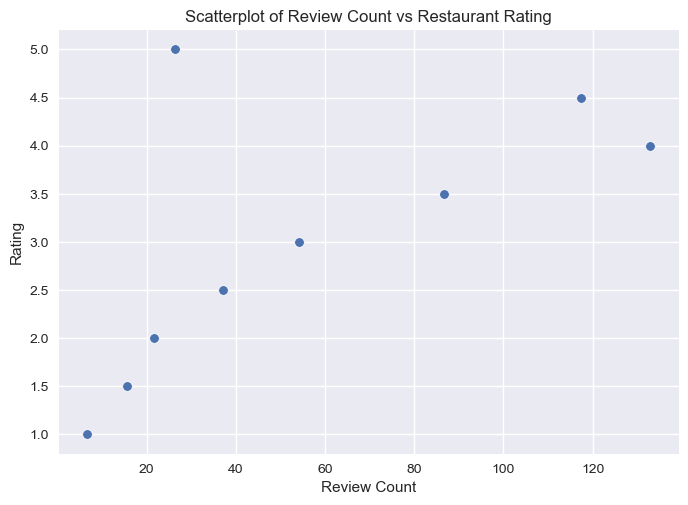

In [297]:
review_byrating = yelp_wage_income.pivot_table(values="review_count", index="stars")
review_byrating = revirew_byrating.reset_index()
ax = sns.scatterplot(x="review_count", y="stars", data=review_byrating, ci=None)
plt.xlabel("Review Count")
plt.ylabel("Rating")
plt.title("Scatterplot of Review Count vs Restaurant Rating")
plt.show()

One method to make the non-linear relationship between review count and restaurant rating more linear is to apply log transformation to review count, or restaurant rating, or both. After trying these three combinations of log transformations, I find that applying log transformation to both review count and restaurant rating improves linearity between review count and restaurant rating a lot. The scatterplot below shows that the relationship between log review count and log rating is approximately lienar. Thus, the assumption of linearity in linear regression model is met.

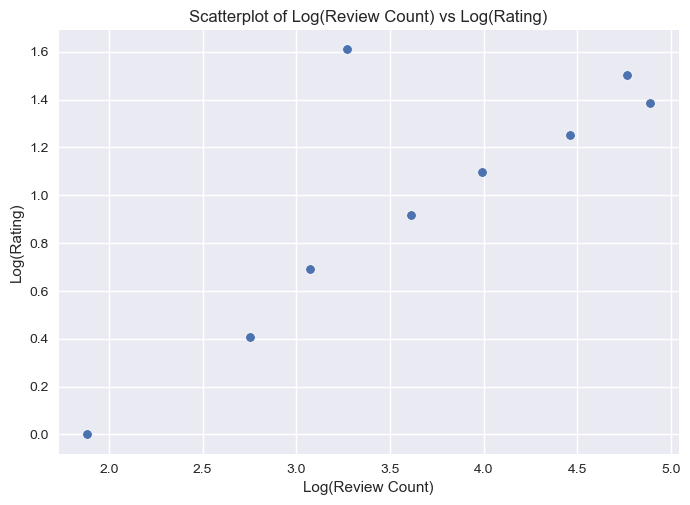

In [296]:
y1 = np.log(review_byrating["stars"])
review_byrating["log(rating)"] = y1
x1 = np.log(review_byrating["review_count"])
review_byrating["log(review count)"] = x1
ax = sns.scatterplot(x="log(review count)", y="log(rating)", data=review_byrating, ci=None)
plt.xlabel("Log(Review Count)")
plt.ylabel("Log(Rating)")
plt.title("Scatterplot of Log(Review Count) vs Log(Rating)")
plt.show()

The scatterplot shows that there exists a non-linear relationship between restaurant rating and number of check-ins. The slope of fitted line is steep for low numbers of check-ins but flattens out when the number of check-ins is high. In other words, restaurant rating changes more dramatically for one additional check-in when the number of check-ins is low. The theory of diminishing marginal returns can explain this trend. 

When the number of check-ins is low, each additional check-in provides a relatively large marginal benefit because it greatly increase the visibility of restaurants and their popularity, which leads to larger impact on the overall restaurant rating. When the number of check-ins is high, however, restaurants are already popular, and the marginal benefit of each additional check-in diminishes. Each additional check-in may not attract more potiental customers as much compared to when the number of check-ins is low and is thus less likely to affect the overall restaurant rating significantly.

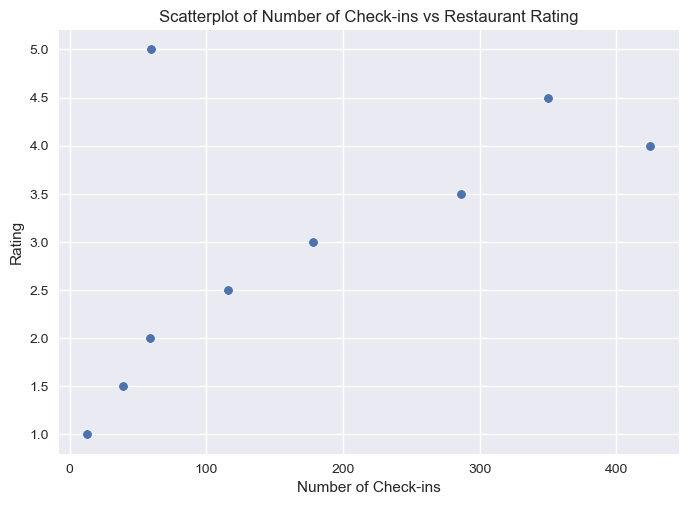

In [295]:
checkin_byrating = yelp_wage_income.pivot_table(values="checkins", index="stars")
checkin_byrating = checkin_byrating.reset_index()
ax = sns.scatterplot(x="checkins", y="stars", data=checkin_byrating, ci=None)
plt.xlabel("Number of Check-ins")
plt.ylabel("Rating")
plt.title("Scatterplot of Number of Check-ins vs Restaurant Rating")
plt.show()

One method to make the non-linear relationship between number of check-ins and restaurant rating more linear is to apply log transformation to number of check-ins, or restaurant rating, or both. After trying these three combinations of log transformations, I find that applying log transformation to both number of check-ins and restaurant rating improves linearity between number of check-ins and restaurant rating a lot. The scatterplot below shows that the relationship between log number of check-inst and log rating is approximately lienar. Thus, the assumption of linearity in linear regression model is met.

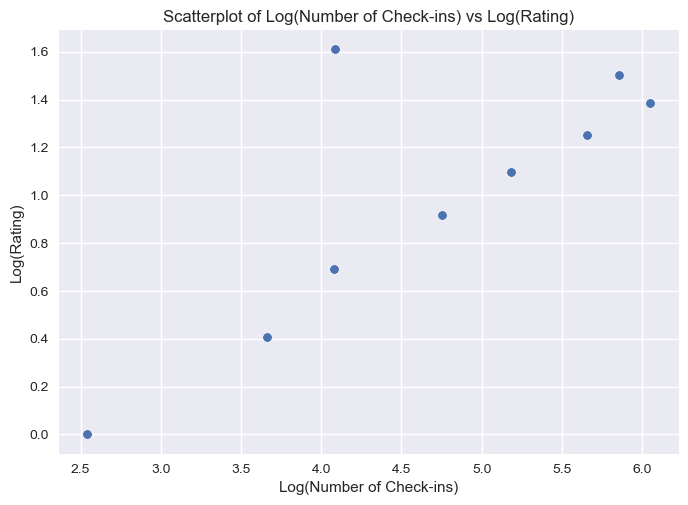

In [300]:
y2 = np.log(checkin_byrating["stars"])
checkin_byrating["log(rating)"] = y2
x2 = np.log(checkin_byrating["checkins"])
checkin_byrating["log(check in)"] = x2
ax = sns.scatterplot(x="log(check in)", y="log(rating)", data=checkin_byrating, ci=None)
plt.xlabel("Log(Number of Check-ins)")
plt.ylabel("Log(Rating)")
plt.title("Scatterplot of Log(Number of Check-ins) vs Log(Rating)")
plt.show()

After applying log transformation, log review count and log number of check-ins both are approximately linearly related to log restuarant rating. Thus, I can use a linear regression model of log restaurant rating on log review count and log number of check-ins to estimate the effects of log review count and log number of check-ins on log restuarant rating.

### Regression 1: Results and Interpretations

The result shows that both log review count and log number of check-ins have statistically significant impact on log restaurant rating at 1% significance level. Holding log number of check-ins constant, the estimated coefficient for log reiview count means that a 1% increase in review count is assoicated with a 0.085% increase in restaurant rating. This positive linear relationship is expected because it is also shown in the scatterplot of log review count vs log restaurant rating. 

Holding log review count constant, the estimated coefficient for log number of check-ins means that a 1% increase in number of check-ins is assoicated with a 0.028% decrease in restaurant rating. This is not expected because the scatterplot of log number of check-ins vs log restaurant rating shows a positive, rather than negative, linear relationship. One possible explanation is that a percentage increase in number of check-ins implies that a large number of customers are visiting the restaurants. Restaurants may not be able to meet the increased demand because they have limited spaces, staffs, and prepared ingredients. Customers may need to wait longer time for their food and experience lower quality of service. This decrease customer satisfaction and results in lower restaurant ratings. 

In [36]:
yelp_wage_income['constant'] = 1
y3 = np.log(yelp_wage_income["stars"])
yelp_wage_income["log(rating)"] = y3
x3 = np.log(yelp_wage_income["review_count"])
yelp_wage_income["log(review count)"] = x3
x4 = np.log(yelp_wage_income["checkins"])
yelp_wage_income["log(check in)"] = x4

In [294]:
X1 = ['constant', 'log(review count)', 'log(check in)']
reg1 = sm.OLS(yelp_wage_income['log(rating)'], yelp_wage_income[X1], missing='drop').fit()
stargazer = Stargazer([reg1])
stargazer.custom_columns(["log(rating)"],[1])
HTML(stargazer.render_html())

### Regression 2: Regressors

The scatterplot shows that there exists a non-linear relationship between restaurant rating and real minimum wage at state level. The slope of fitted line is steep for low real minimum wage but flattens out when real minimum wage is high. In other words, restaurant rating changes more dramatically for one additional dollor of real minimum wage when real minimum wage is low. The theory of diminishing marginal returns can explain this trend.

When real minimum wage is low, a one dollar increase in minimum wage leads to a proportionately larger increase in labor costs, which could force restaurants to increase their menu prices or cut spendings in other areas more dramatically, resulting in relatively larger decrease in ratings. When real minimum wage is high, restaurants already incur high labor costs. Each additional dollor of real minimum wage is a relatively small increase in labor costs, so restaurants may choose to absorb the increased costs or slightly adjust their prices and spendings in other areas, which leads to proportionately smaller decrease in ratings.

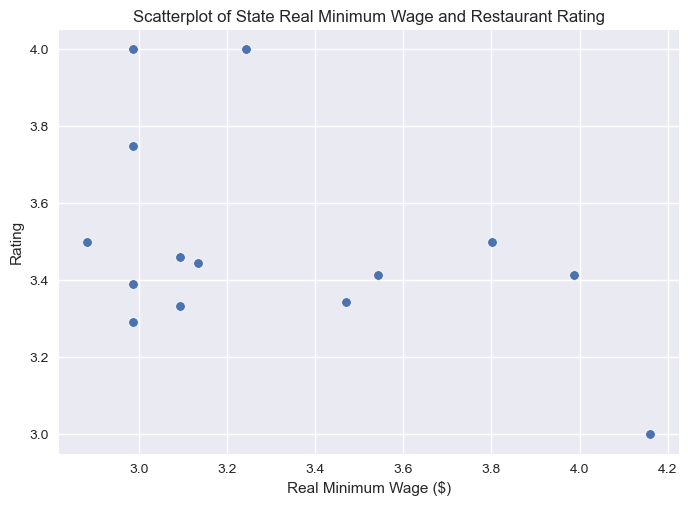

In [298]:
ax = sns.scatterplot(x="real min wage ($)", y="stars", data=realwage_rating, ci=None)
plt.xlabel("Real Minimum Wage ($)")
plt.ylabel("Rating")
plt.title("Scatterplot of State Real Minimum Wage and Restaurant Rating")
plt.show()

From the scatterplot, the relationship between real minimum wage and restaurant rating can be approximately expressed in the following form: $rating_i = ae^{-b*minwage_i}$ where a and b are positive constants. To linearize their relationship, I take the log of both sides of the equation, so that $log(rating_i) = log(a) - b*minwage_i$. Log real minimum wage is now approximately linearly related to log restaurant rating. Leaving out log real minimum wage that affects log restaurant rating will result in omitted variable bias, yielding biased estimate of coefficients. To solve this, I include log real minimum wage, in addition to log review count and log number of check-ins, as my regressors in linear regression model. The model estimates the effects of log review count, log number of check-ins, and log real minimum wage on log restuarant rating.

### Regression 2: Results and Interpretations

The result shows that log review count, log number of check-ins, and log real minimum wage have statistically significant impact on log restaurant rating at 1% significance level. Holding the other variables constant,

(1) the estimated coefficient for log reiview count means that a 1% increase in review count is assoicated with a 0.085% increase in restaurant rating

(2) the estimated coefficient for log number of check-ins means that a 1% increase in number of check-ins is assoicated with a 0.027% decrease in restaurant rating

Compared to my first model, the effect of log number of check-ins on log restaurant rating slightly decrease, while the effect of log review count on restaurant rating stays the same.

The estimated coefficient for log number of real minimum wage means that a 1% increase in real minimum wage is assoicated with a 0.071% decrease in restaurant rating, holding constant the other variables. This negative linear relationship is expected because it is also shown by the equation mentioned before. The adjusted R-squared increases from 0.083 to 0.084, meaning that the regressors in my second model explain slighly more variation in log restaurant rating than the regressors in my first model. Adding log real minimum wage improves model fit, so I should include real minimum wage in linear regression model. 

In [37]:
x5 = np.log(yelp_wage_income["real min wage ($)"])
yelp_wage_income["log(real minimum wage)"] = x5
X2 = ['constant', 'log(review count)', 'log(check in)', "log(real minimum wage)"]
reg2 = sm.OLS(yelp_wage_income['log(rating)'], yelp_wage_income[X2], missing='drop').fit()
stargazer = Stargazer([reg2])
stargazer.custom_columns(["log(rating)"],[1])
HTML(stargazer.render_html())

### Regression 3: Regressors

The scatterplot shows that there exists a non-linear relationship between restaurant rating and median household income at state level. The slope of fitted line is flatter for low median household income but becomes steep when median household income is high. In other words, restaurant rating changes more dramatically for one additional dollor of median household income when median household income is high. The concepts of income elasticity of demand and luxury goods can explain this trend.

High-rating restaurants can be considered as luxury goods because the demand for high-rating restaurants increases as customer wealth increases. The income elasticity of demand for luxury goods is higher for high-income customers. For high-income households, a one dollar increase in median household income leads to larger increase in customer demand of high-rating restaurants, so restaurants tend to greatly improve their performance to meet higher standards of high-income households. For low-income households, a one dollar increase in median household income is more likely to be spent on necessity goods instead of luxury goods, so the demand of high-rating restaurants does not increase as much. Thus, restaurants may not improve their performance greatly, which leads to lower increase in restaurant ratings.

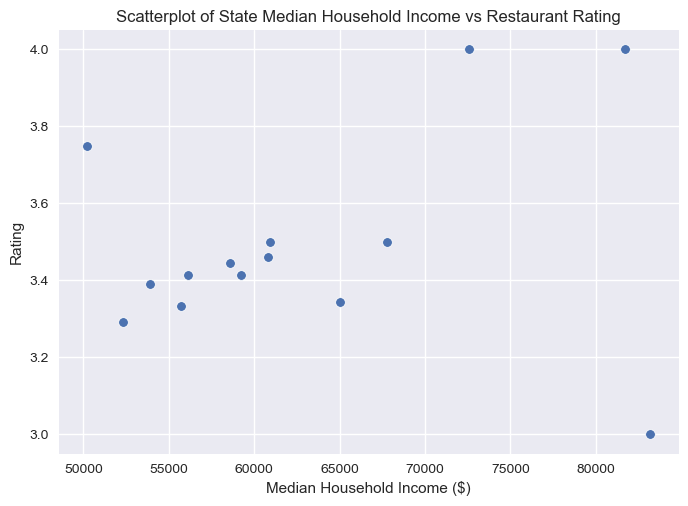

In [304]:
ax = sns.scatterplot(x="median household income ($)", y="stars", data=income_rating, ci=None)
plt.xlabel("Median Household Income ($)")
plt.ylabel("Rating")
plt.title("Scatterplot of State Median Household Income vs Restaurant Rating")
plt.show()

From the scatterplot, the relationship between median household income and restaurant rating is approximately exponential and can be expressed in the following form: $rating_i = ae^{b*income_i}$ where a and b are positive constants. To linearize their relationship, I take the log of both sides of the equation, so that $log(rating_i) = log(a) + b*income_i$. Log median household income is now approximately linearly related to log restaurant rating. Leaving out log median household income that affects log restaurant rating will result in omitted variable bias, yielding biased estimate of coefficients. To solve this, I include log median household income, in addition to log review count, log number of check-ins, and log real minimum wage, as my regressors in linear regression model. The model estimates the effects of log review count, log number of check-ins, log real minimum wage, and log median household income on log restuarant rating.

### Regression 3: Results and Interpretations

The result shows that log review count, log number of check-ins, and log real minimum wage have statistically significant impact on log restaurant rating at 1% significance level, while the relationship between log median household income and restaurant rating is not statistically significant. Holding the other variables constant,

(1) the estimated coefficient for log reiview count means that a 1% increase in review count is assoicated with a 0.084% increase in restaurant rating

(2) the estimated coefficient for log number of check-ins means that a 1% increase in number of check-ins is assoicated with a 0.027% decrease in restaurant rating

(3) the estimated coefficient for log number of real minimum wage means that a 1% increase in real minimum wage is assoicated with a 0.074% decrease in restaurant rating. 

Compared to my second model, the effect of log review count on log restaurant rating slightly decrease; the effect of log number of check-ins on restaurant rating stays the same; the effect of log real minimum wage on log restaurant rating slihgtly increase.

The estimated coefficient for log median household income means that a 1% increase in median household income is assoicated with a 0.058% increase in restaurant rating, holding constant the other variables. Since this coefficient is not statistically significant, median household income may not be an important factor affecting restaurant rating. The adjusted R-squared does not change, but mean squared error decreases, meaning that the average squared difference between the predicted values and actual values is smaller in my third model. Adding log median household income improves model fit, so I should include median household income in linear regression model.

In [38]:
x6 = np.log(yelp_wage_income["median household income ($)"])
yelp_wage_income["log(median household income)"] = x6
X3 = ['constant', 'log(review count)', 'log(check in)', 'log(real minimum wage)', 'log(median household income)']
reg3 = sm.OLS(yelp_wage_income['log(rating)'], yelp_wage_income[X3], missing='drop').fit()
stargazer = Stargazer([reg3])
stargazer.custom_columns(["log(rating)"],[1])
HTML(stargazer.render_html())

### Regression 4: Regressors

From the boxplot for US restaurants in Yelp dataset, the distribution of ratings for US restaurants without parking available is slightly left-skewed compared to the distribution of ratings for US restaurants with parking available. This shows that US restaurants without parking available receive slightly lower average rating than US restaurants with parking available, implying that whether restaurants offer parking does affects their ratings. Also, several studies have indicated that customers going to restaurants with parking facilities tend to give higher ratings (SangeethaGunasekar 2018; Bilgihan et al. 2018). This is because restaurants with parking available offer convenience to customers and satisfy the needs of large groups or families who often require parking spaces. 

Because availability of parking is related to restaurant rating, leaving out log median household income that affects log restaurant rating will result in omitted variable bias, yielding biased estimate of coefficients. To solve this, I include availability of parking, in addition to log review count, log number of check-ins, log real minimum wage, and log median household income, as my regressors in linear regression model. The model estimates the effects of log review count, log number of check-ins, log real minimum wage, log median household income, and availability of parking on log restuarant rating.

Text(0.5, 1.0, 'Boxplot of Restaurant Availability of Parking vs Rating')

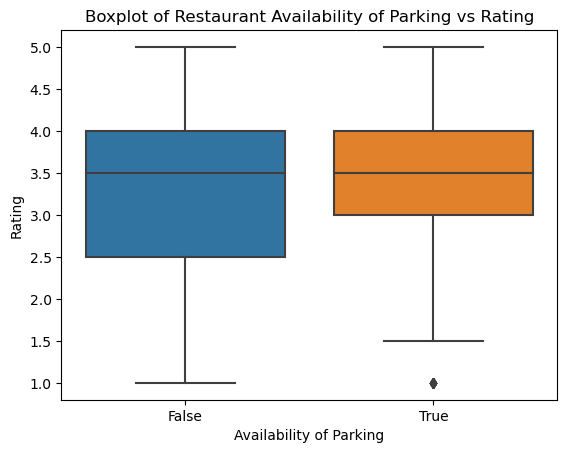

In [27]:
sns.boxplot(x="parking", y="stars", data=yelp_wage_income) 
plt.xlabel("Availability of Parking")
plt.ylabel("Rating")
plt.title("Boxplot of Restaurant Availability of Parking vs Rating")

### Regression 4: Results and Interpretations

The result shows that log review count, log number of check-ins, log real minimum wage, and availability of parking have statistically significant impact on log restaurant rating at 1% significance level, while the relationship between log median household income and restaurant rating is not statistically significant. Holding the other variables constant,

(1) the estimated coefficient for log reiview count means that a 1% increase in review count is assoicated with a 0.076% increase in restaurant rating 

(2) the estimated coefficient for log number of check-ins means that a 1% increase in number of check-ins is assoicated with a 0.027% decrease in restaurant rating

(3) the estimated coefficient for log number of real minimum wage means that a 1% increase in real minimum wage is assoicated with a 0.072% decrease in restaurant rating 

(4) the estimated coefficient for log median household income means that a 1% increase in median household income is assoicated with a 0.045% increase in restaurant rating

Compared to my third model, the effect of log review count, log real minimum wage, and log median household income on log restaurant rating slightly decrease, while the effect of log number of check-ins on restaurant rating stays the same.

All else equal, the estimated coefficient for availability of parking means that offering parking is assoicated with a 5.5% increase in restaurant rating. The adjusted R-squared increases from 0.084 to 0.093, meaning that the regressors in my fourth model explain more variation in log restaurant rating than the regressors in my third model. Adding availability of parking improves model fit, so I should include availability of parking in linear regression model.

In [23]:
yelp_wage_income["parking_dummy"] = 0
for i in range(yelp_wage_income.shape[0]):
    if yelp_wage_income["parking"][i] != 'False':
        yelp_wage_income["parking_dummy"][i] = 1

In [320]:
X4 = ['constant', 'log(real minimum wage)', 'log(median household income)', 
      'log(review count)', 'log(check in)', 'parking_dummy']
reg4 = sm.OLS(yelp_wage_income['log(rating)'], yelp_wage_income[X4], missing='drop').fit()
stargazer = Stargazer([reg4])
stargazer.custom_columns(["log(rating)"],[1])
HTML(stargazer.render_html())

### Comparing Regressions

Among the four specifications, Model 4 has the highest adjusted R-squared and lowest mean squared error. The R-squared for Model 4 is 0.093, which means that 9.3% of variation in log restaurant rating is explained by the predictors in the model, after adjusting for the number of predictors. The regressors in Model explain more variation in log restaurant rating than the regressors in other models. Model 4 has the lowest mean squared error, which means that the average squared difference between the predicted values and actual values is the smallest in Model 4. Model 4 yields better predictions than other models. Because Model 4 has the highest adjusted R-squared and lowest mean squared error, Model 4 best fits my data and is thus the most accurate model among the four specifications. Thus, Model 4 is my preferred specification. 

In [323]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.custom_columns(["log(rating)"],[4])
HTML(stargazer.render_html())

In [312]:
df1 = yelp_wage_income[['log(review count)', 'log(check in)']]
yelp_lr_model = linear_model.LinearRegression()
yelp_lr_model.fit(df1, yelp_wage_income['log(rating)'])
mse1 = metrics.mean_squared_error(yelp_wage_income['log(rating)'], yelp_lr_model.predict(df1))
print('Mean Squared Error for Model 1 is', mse1)

Mean Squared Error for Model 1 is 0.06673907280630947


In [313]:
df2 = yelp_wage_income[['log(review count)', 'log(check in)', 
                        'log(real minimum wage)']]
yelp_lr_model2 = linear_model.LinearRegression()
yelp_lr_model2.fit(df2, yelp_wage_income['log(rating)'])
mse2 = metrics.mean_squared_error(yelp_wage_income['log(rating)'], yelp_lr_model2.predict(df2))
print('Mean Squared Error for Model 2 is', mse2)

Mean Squared Error for Model 2 is 0.06666034458788908


In [316]:
df3 = yelp_wage_income[['log(review count)', 'log(check in)', 
                        'log(real minimum wage)', 'log(median household income)']]
yelp_lr_model3 = linear_model.LinearRegression()
yelp_lr_model3.fit(df3, yelp_wage_income['log(rating)'])
mse3 = metrics.mean_squared_error(yelp_wage_income['log(rating)'], yelp_lr_model3.predict(df3))
print('Mean Squared Error for Model 3 is', mse3)

Mean Squared Error for Model 3 is 0.06665506341825667


In [1]:
df4 = yelp_wage_income[['log(review count)', 'log(check in)', 
                        'log(real minimum wage)', 'log(median household income)', 
                        'parking_dummy']]
yelp_lr_model4 = linear_model.LinearRegression()
yelp_lr_model4.fit(df4, yelp_wage_income['log(rating)'])
mse4 = metrics.mean_squared_error(yelp_wage_income['log(rating)'], yelp_lr_model4.predict(df4))
print('Mean Squared Error for Model 4 is', mse4)

NameError: name 'yelp_wage_income' is not defined

## Machine Learning

### Objective Function

The objective function is to find the number of terminal nodes in the tree $T$ that minimizes the sum of squared difference between the actual values and predicted values of restaurant rating (predicted values are the average rating of training restaurants located in the region $R_m$) for each mutually exclusive region plus a penalty term that is the tree's tuning parameter $\alpha$ times the number of terminal nodes $T$. It's basically minimizing mean squared error.

$$
\min_{T} \left[  \sum_{m=1}^{|T|} \sum_{i \in R_m} (stars_i - \widehat{stars}_{R_m})^2 + \alpha |T| \right] 
$$

The tree's tuning parameter is $\alpha$, which controls the trade-off between complexity and quality of the fit to training data. It's the parameter that helps avoid overfitting. When $\alpha$ is high, the penalty for having a complex tree is large, so the model that minimizes mean squared error is a simple model with fewer branches. This model does not fit the training data well but is less likely to overfit, leading to good test set performance. When $\alpha$ is low, the penalty for having a complex tree is small, so the model that minimizes mean squared error can be a complex model with more branches. This model fits the training data well but is more likely to overfit, leading to poor test set performance. 

### Regression Tree

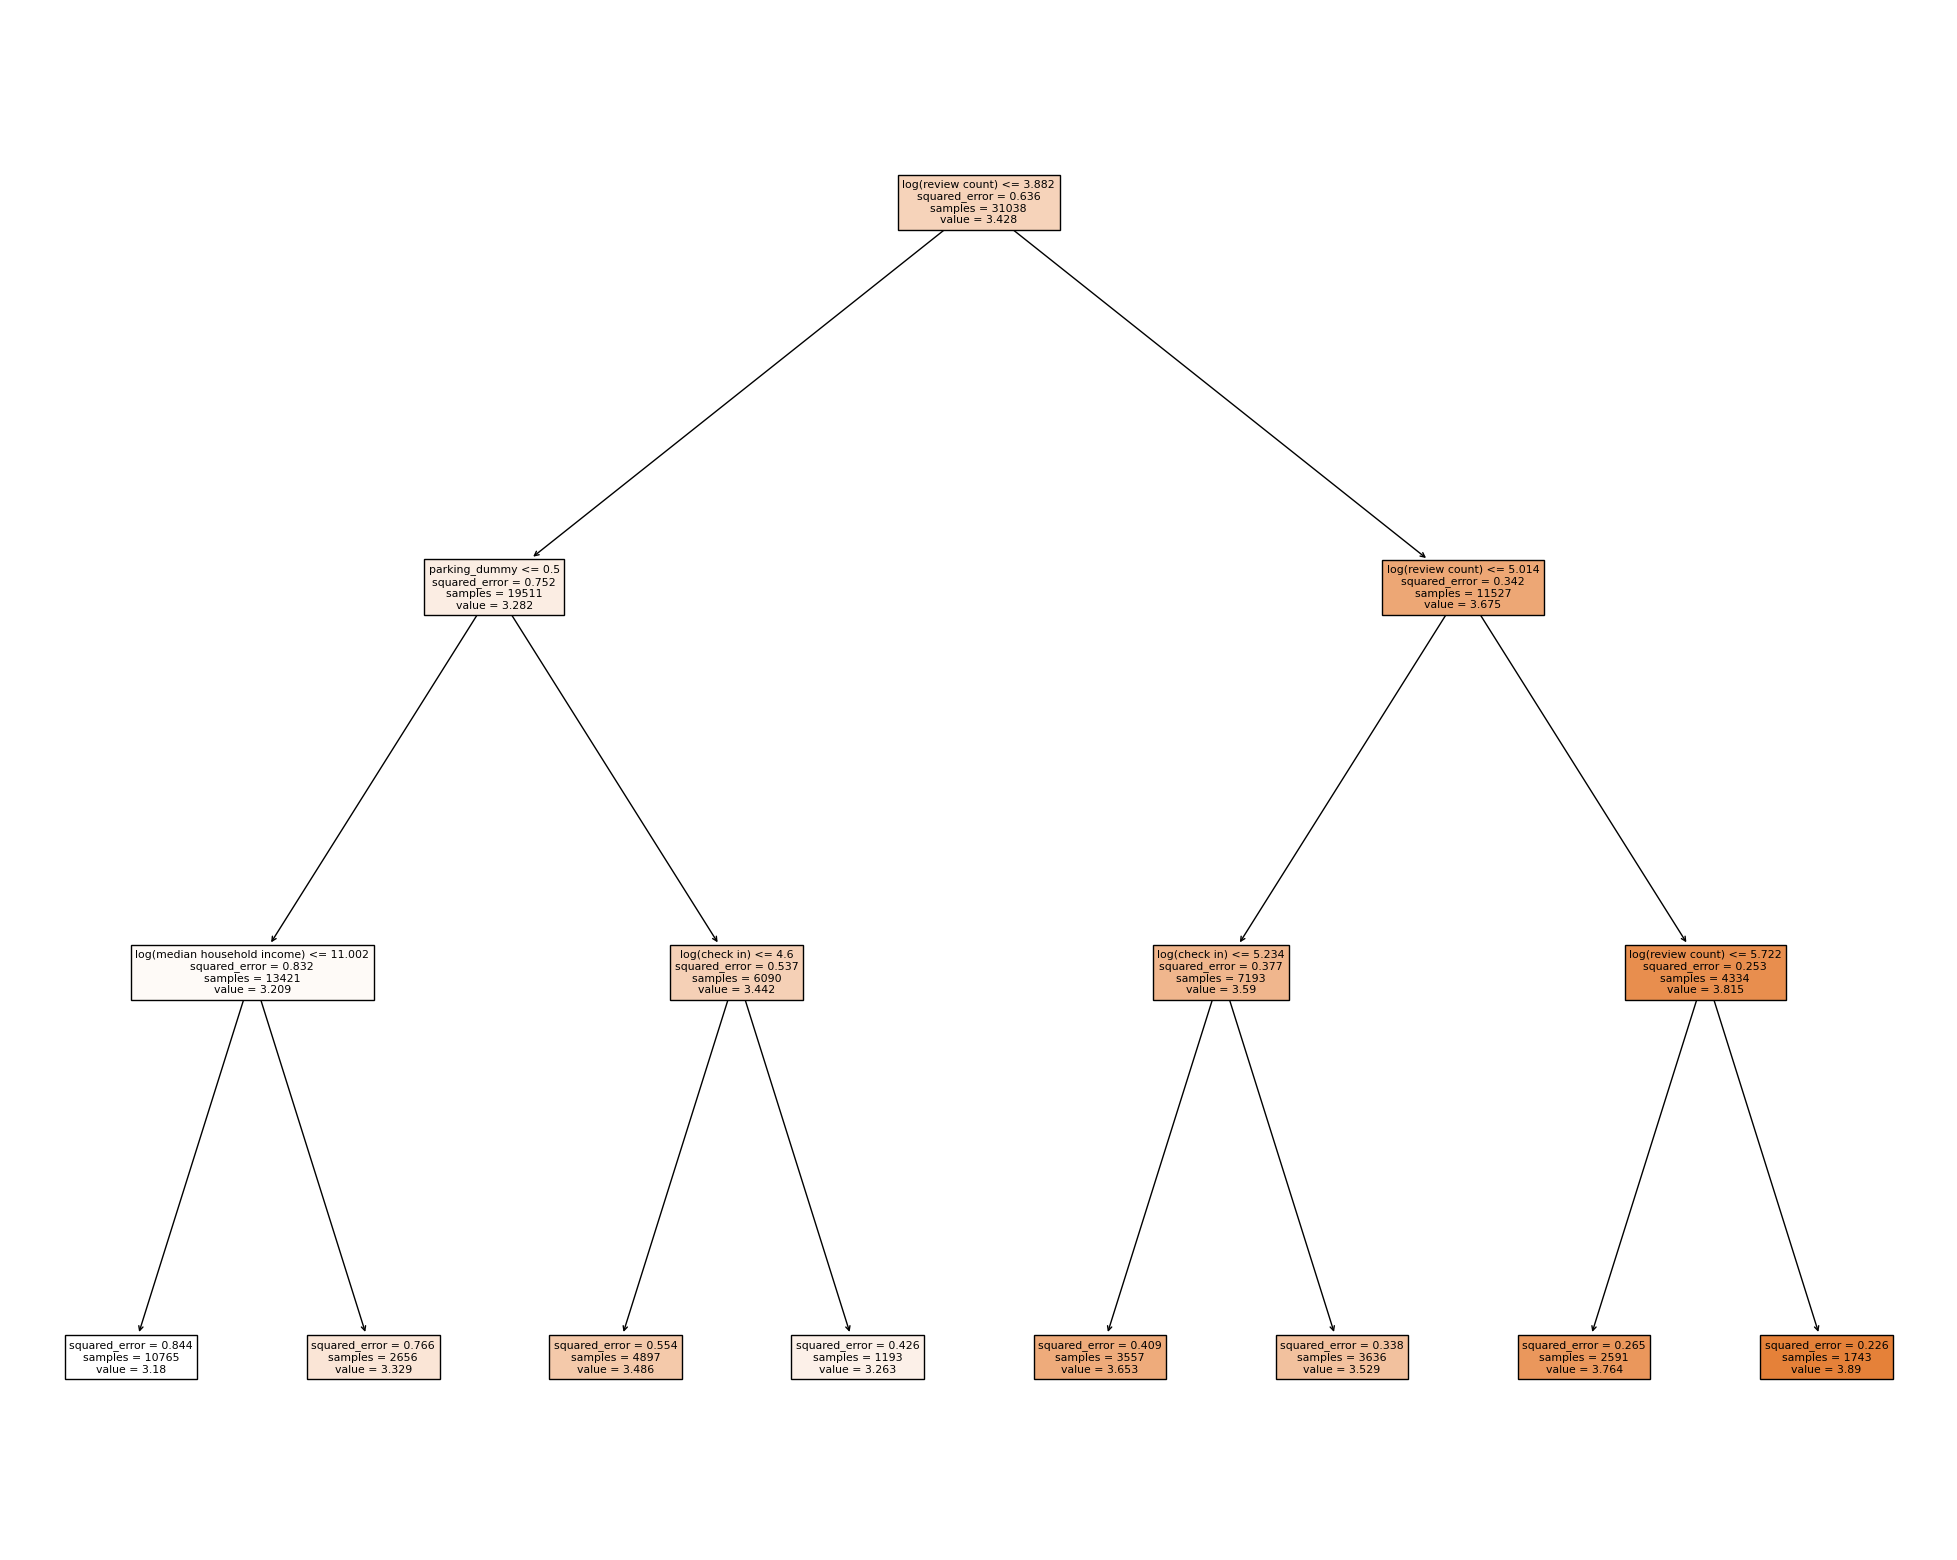

In [42]:
yelp_tree = tree.DecisionTreeRegressor(max_depth=3).fit(df4,yelp_wage_income['stars'])
yelp_tree_fig = plt.figure(figsize=(25,20))
yelp_tree_fig = tree.plot_tree(yelp_tree, feature_names=df4.columns, filled=True)

In [43]:
# use the fitted tree to predict
y_pred_tree = yelp_tree.predict(df4)

# find the error of prediction (MSE)
print('Mean Squared Error:', metrics.mean_squared_error(yelp_wage_income['stars'], y_pred_tree))

Mean Squared Error: 0.5834493188155125


# References

Balázs Kovács, Glenn R. Carroll, David W. Lehman. (2013). Authenticity and Consumer Value Ratings: Empirical Tests from the Restaurant Domain. Organization Science 25(2):458-478. https://doi.org/10.1287/orsc.2013.0843

Bilgihan, A., Seo, S., & Choi, J. (2018). Identifying restaurant satisfiers and dissatisfiers: Suggestions from online reviews. Journal of Hospitality Marketing & Management, 27(5), 601-625.

Digest of Education Statistics (2019). National Center for Education Statistics (NCES) Home Page, a part of the U.S. Department of Education. (n.d.). https://nces.ed.gov/programs/digest/d19/tables/dt19_102.30.asp 

Luca, Michael, and Oren Reshef. (July 2021). "The Effect of Price on Firm Reputation." Management Science 67, no. 7: 4408–4419. https://doi.org/10.1287/mnsc.2021.4049.

Luo, Y., & Xu, X. (2019). Predicting the helpfulness of online restaurant reviews using different machine learning algorithms: A case study of yelp. Sustainability, 11(19), 5254.

SangeethaGunasekar, A. N. S. (2018). Impact of restaurant’s features on the reviews and rat-ings. International Journal of Pure and Applied Mathematics, 119(7), 239-246.

Shantanu Khanna. (2021). Many channels of adjustment to a higher minimum wage: Evidence from Restaurant Reviews. https://economics-dev.ss.uci.edu/files/docs/2021/gradjobmarket/khanna_shantanu.pdf.

U.S. Bureau of Labor Statistics. Regional Resources. U.S. Bureau of Labor Statistics. https://www.bls.gov/cpi/regional-resources.htm.

Ziqiong Zhang, Qiang Ye, Rob Law, Yijun Li. (2010). The impact of e-word-of-mouth on the online popularity of restaurants: A comparison of consumer reviews and editor reviews. International Journal of Hospitality Management,
Volume 29, Issue 4, Pages 694-700, ISSN 0278-4319. https://doi.org/10.1016/j.ijhm.2010.02.002.